# Recency, Frequency and Monetary Analysis on H&M Data

## 1 Import libraries

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2 Data pre-processing for RFM
- Check variables
- Derive Recency, Frequency and Monetary variables

### 2.1 Read in CSV and Conduct Basic Analysis

In [3]:
# Read in CSV
df = pd.read_csv('data/transactions_train.csv')
print('Dataframe shape:',df.shape)
print('Columns:',list(df.columns))
df.head()

Dataframe shape: (31788324, 5)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [4]:
# Basic data check: Check for null values
for col in df.columns:
    print("Number of Null Values in", col, " : ", len(df[df[col].isna()]), "/", len(df))

Number of Null Values in t_dat  :  0 / 31788324
Number of Null Values in customer_id  :  0 / 31788324
Number of Null Values in article_id  :  0 / 31788324
Number of Null Values in price  :  0 / 31788324
Number of Null Values in sales_channel_id  :  0 / 31788324


In [5]:
# Basic data check: Check data types
df.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [6]:
# Change data type
df = df.astype({'t_dat':'datetime64[ns]',
                'customer_id':'str',
                'article_id':'str',
                'price':'float',
                'sales_channel_id':'str'})
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                  object
price                      float64
sales_channel_id            object
dtype: object

In [7]:
# Subset relevant columns and 
# Change order of dataframe to place customer_id at the front
cols = ['customer_id','t_dat','price','article_id']
df_new = df[cols]
df_new.head()

,customer_id,t_dat,price,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.015237,505221004
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687003
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687004


### 2.2 Create dataframe for RFM analysis

#### Check number of unique customers

In [8]:
# Check number of unique customers
len(df['customer_id'].unique())

1362281

#### Recency

In [9]:
# Subset dataset to get customer_id and t_dat to compute recency
df_recency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_recency) == len(df)) # check
# df_recency.head()

True


In [10]:
print(df_recency['t_dat'].max())

2020-09-22 00:00:00


In [11]:
# Get last date of purchase
df_recency = pd.DataFrame(df_recency.groupby('customer_id')['t_dat'].max()).reset_index()
print(len(df_recency) == len(df_new['customer_id'].unique()))
# df_recency.head()

True


In [12]:
# Calculate recency based on 2020-10-01
date = dt.datetime(2020, 10, 1)
df_recency['Recency'] = df_recency.t_dat.apply(lambda x:(date - x).days)
df_recency.head()

,customer_id,t_dat,Recency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,26
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2020-07-08,85
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,16
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09,480
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,50


#### Frequency

In [13]:
# Subset dataset to get customer_id and t_dat to compute frequency
df_frequency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_frequency) == len(df)) # check
# df_frequency.head()

True


In [14]:
# Calculate frequency based on total number of purchases
df_frequency = pd.DataFrame(df_frequency.groupby('customer_id')['t_dat'].count()).reset_index()
print(len(df_frequency) == len(df_new['customer_id'].unique()))
df_frequency.columns = ['customer_id', 'Frequency']
df_frequency.head()

True


,customer_id,Frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,21
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,86
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,13


#### Monetary

In [15]:
# Subset dataset to get customer_id and price to compute monetary
df_monetary = df_new.loc[:,['customer_id','price']]
print(len(df_monetary) == len(df)) # check
# df_monetary.head()

True


In [16]:
# Calculate monetary based on average amount spent per transaction
df_monetary = pd.DataFrame(df_monetary.groupby('customer_id')['price'].mean()).reset_index()
print(len(df_monetary) == len(df_new['customer_id'].unique()))
df_monetary.columns = ['customer_id', 'Monetary']
df_monetary.head()

True


,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.030904
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.030255
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.039154
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.030492
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.036130


## 3 RFM analysis
https://github.com/klaudia-nazarko/rfm-analysis-python/blob/master/rfm_analysis_python.ipynb

### 3.1 Combine RFM into a single dataframe
- `Recency`: Number of days from latest transaction date to 2020-10-1 (because the latest t_dat in dataset is 2020-9-22 so chose 2020-10-1 as a reasonable benchmark)
- `Frequency`: Number of transactions per customer_id
- `Money`: Average spending per transaction

In [17]:
df_rfm = pd.merge(df_recency, df_frequency, on='customer_id')
df_rfm = pd.merge(df_rfm, df_monetary, on='customer_id')
df_rfm = df_rfm.drop(['t_dat'], axis=1)
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (1362281, 4)


,customer_id,Recency,Frequency,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,0.030904
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,0.030255
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,0.039154
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,0.030492
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,0.036130


### 3.2 Conduct RFM Analysis by grouping customers into segments
- Recency: (shortened interval because shopping for clothes is a necessity)
    - Active: Purchase within past 6 months
    - Warm: Purchase within past 1 year
    - Cold/Lost: Purchase beyond 1 year
- Frequency:
    - Frequent: Top 50% quartile
    - Less frequent: Bottom 50% quartile
- Monetary:
    - Valuable: Top 20%
    - Less valuable: Bottom 80%

In [18]:
# assign recency label
bins = [0,6*30,12*30,1000]

r_labels = ['Active','Warm','Cold/Lost']
df_rfm['r_label'] = pd.cut(df_rfm['Recency'], bins=bins, labels=r_labels, right=False)

# r_scores = [4,3,2,1]
# df_rfm['r_score'] = pd.cut(df_rfm['Recency'], bins=bins, labels=r_scores, right=False).astype(int)

In [19]:
# assign frequency label
f_labels = ['Less frequent','Frequent']
df_rfm['f_label'] = pd.qcut(df_rfm['Frequency'], q=2, labels=f_labels)

# f_scores = [1,2,3]
# df_rfm['f_score'] = pd.qcut(df_rfm['Frequency'], q=3, labels=f_scores).astype(int)

In [20]:
# assign monetary label
bins = [0, np.percentile(df_rfm.Monetary,20), 1]

m_labels = ['Less valuable','Valuable']
df_rfm['m_label'] = pd.cut(df_rfm['Monetary'], bins=bins, labels=m_labels, right=False)

# m_scores = [2,1]
# df_rfm['m_score'] = pd.cut(df_rfm['Monetary'], bins=bins, labels=m_scores, right=False).astype(int)

In [21]:
# Add a column to sum rfm scores
# df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,r_label,f_label,m_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,0.030904,Active,Frequent,Valuable
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,0.030255,Active,Frequent,Valuable
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,0.039154,Active,Frequent,Valuable
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,0.030492,Cold/Lost,Less frequent,Valuable
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,0.036130,Active,Frequent,Valuable


#### RFM Customer Segments
- Champions: High on all RFM factors
- Big spenders: High on Monetary
- Loyal: May not have high Monetary, but high on Recency and Frequency (i.e. visits stores often, maybe to check out new goods)
- Needs attention: Relatively high Recency or Frequency, but low Monetary (i.e. potentially able to focus on increasing profitability from this segment e.g. by using marketing campaigns to push products to them with greater force?)
- Potential re-activation: Low on Recency and Frequency, but high Monetary (i.e. able to spend)
- Unprofitable: Low Recency and Monetary (i.e. no point investing in these customers)

In [22]:
def assign_label(df, r_label, f_label, m_label, label, colname='rfm_label'):
    df.loc[(df['r_label']==r_label) & (df['f_label']==f_label)
              & (df['m_label']==m_label), colname] = label
    return df

# def assign_label(df, r_rule, f_rule, m_rule, label, colname='rfm_label'):
#     df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
#             & (df['f_score'].between(f_rule[0], f_rule[1]))
#             & (df['m_score'].between(m_rule[0], m_rule[1])), colname] = label
#     return df

In [23]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Valuable', 'Champions')
df_rfm = assign_label(df_rfm, 'Active', 'Less frequent', 'Valuable', 'Big spenders')
df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Less valuable', 'Loyal')
df_rfm = assign_label(df_rfm, 'Active', 'Less frequent', 'Less valuable', 'Needs attention')

df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Valuable', 'Big spenders')
df_rfm = assign_label(df_rfm, 'Warm', 'Less frequent', 'Valuable', 'Big spenders')
df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Less valuable', 'Needs attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Less frequent', 'Less valuable', 'Unprofitable')

df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Frequent', 'Valuable', 'Potential re-activation')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Less frequent', 'Valuable', 'Potential re-activation')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Frequent', 'Less valuable', 'Unprofitable')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Less frequent', 'Less valuable', 'Unprofitable')

In [24]:
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (1362281, 8)


,customer_id,Recency,Frequency,Monetary,r_label,f_label,m_label,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,0.030904,Active,Frequent,Valuable,Champions
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,0.030255,Active,Frequent,Valuable,Champions
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,0.039154,Active,Frequent,Valuable,Champions
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,0.030492,Cold/Lost,Less frequent,Valuable,Potential re-activation
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,0.036130,Active,Frequent,Valuable,Champions


In [25]:
df_rfm['rfm_label'].unique()

array(['Champions', 'Potential re-activation', 'Big spenders',
       'Unprofitable', 'Needs attention', 'Loyal'], dtype=object)

## 3.3 RFM Segment Analysis

### 3.3.1 General Analysis on RFM Segments

#### Number of customers in each RFM Segment defined

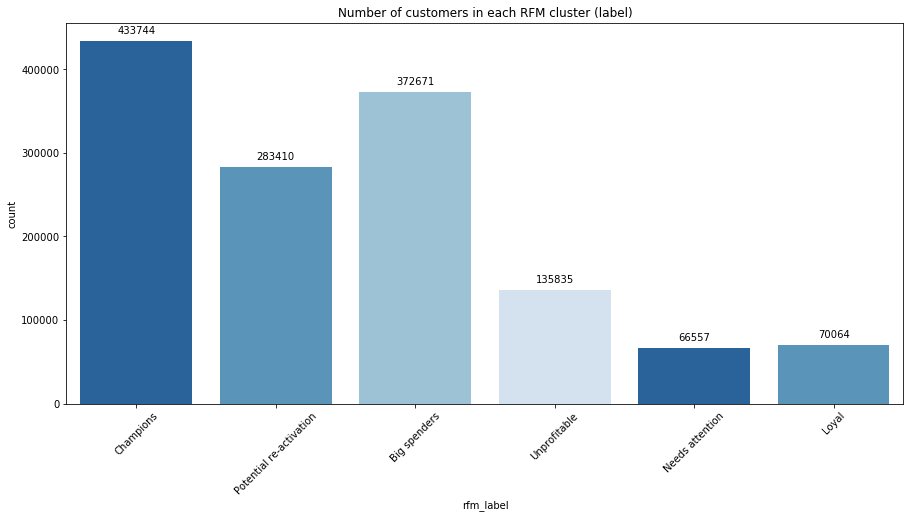

In [26]:
palette = sns.color_palette("Blues_r", n_colors=7)

for rfm_type in ['label']:
    fig, ax = plt.subplots(figsize=(15,7))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')
    ax.set_title('Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=45)
    plt.show()

#### Proportion of customers in each RFM Segment & Proportion of monetary amount by customers in each RFM Segment

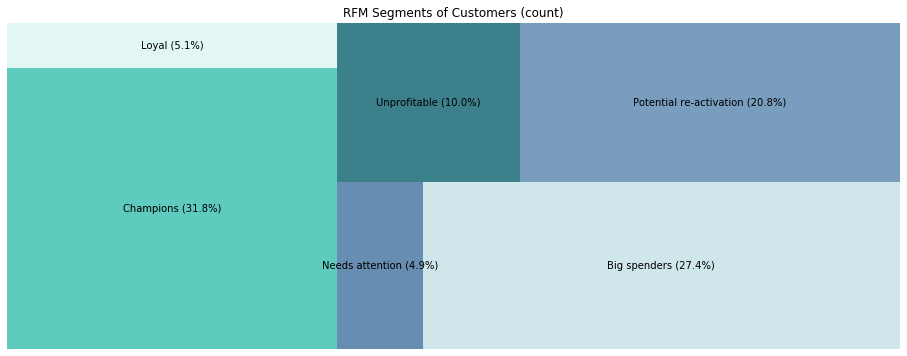

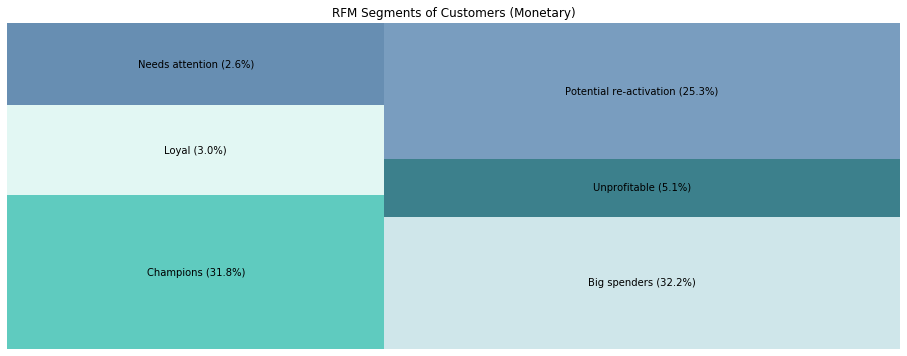

In [27]:
import squarify
agg_dict2 = {
    'customer_id': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'sum'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='Recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customer_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['Monetary_share'] = df_analysis['Monetary'] / df_analysis['Monetary'].sum()
df_analysis['Monetary'] = df_analysis['Monetary'] / df_analysis['count']

colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'Monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

#### View Recency vs Frequency for each RFM Segment for comparison

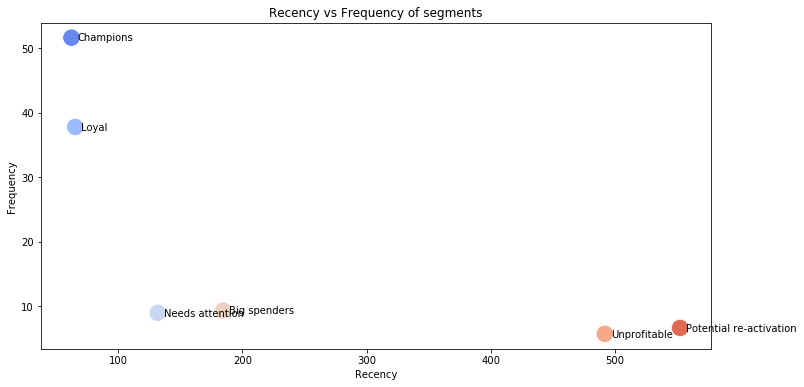

In [29]:
palette = sns.color_palette("coolwarm", 6)

fig, ax = plt.subplots(figsize=(12,6))
plot = sns.scatterplot(x='Recency', y='Frequency', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency'][i]+5,
               df_analysis['Frequency'][i]-0.5,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Frequency of segments')
ax.get_legend().remove()
plt.show()

### 3.3.2 Demographic Analysis of RFM Segments

#### Read in CSV and Conduct Basic Analysis

In [30]:
customers = pd.read_csv('data/customers.csv')
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [31]:
customers = customers.loc[:,['customer_id','Active','club_member_status','fashion_news_frequency','age','postal_code']]
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (1371980, 6)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [32]:
# Basic data check: Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))

Number of Null Values in customer_id  :  0 / 1371980
Number of Null Values in Active  :  907576 / 1371980
Number of Null Values in club_member_status  :  6062 / 1371980
Number of Null Values in fashion_news_frequency  :  16009 / 1371980
Number of Null Values in age  :  15861 / 1371980
Number of Null Values in postal_code  :  0 / 1371980


In [33]:
# Handle null values
customers['Active'] = customers['Active'].fillna(0)
customers['club_member_status'] = customers['club_member_status'].fillna('NONE')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('None')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace(['NONE'],'None')
customers = customers.dropna(subset=['age'])

# Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))
    
customers.dtypes

Number of Null Values in customer_id  :  0 / 1356119
Number of Null Values in Active  :  0 / 1356119
Number of Null Values in club_member_status  :  0 / 1356119
Number of Null Values in fashion_news_frequency  :  0 / 1356119
Number of Null Values in age  :  0 / 1356119
Number of Null Values in postal_code  :  0 / 1356119


customer_id                object
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

In [34]:
# Convert datatypes to suitable datatypes
customers = customers.astype({'customer_id':'str',
                              'Active':'category',
                              'club_member_status':'category',
                              'fashion_news_frequency':'category',
                              'age':'int64',
                              'postal_code':'category'})
customers.dtypes

customer_id                 object
Active                    category
club_member_status        category
fashion_news_frequency    category
age                          int64
postal_code               category
dtype: object

In [35]:
rfm_customers = customers.merge(df_rfm[['customer_id','Recency','Frequency','Monetary','rfm_label']], on='customer_id')
print('Dataframe shape:',rfm_customers.shape)
rfm_customers.head()

Dataframe shape: (1346520, 10)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code,Recency,Frequency,Monetary,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,26,21,0.030904,Champions
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,ACTIVE,None,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,85,86,0.030255,Champions
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,16,18,0.039154,Champions
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,ACTIVE,None,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,480,2,0.030492,Potential re-activation
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,50,13,0.036130,Champions


#### Demographic Analysis 1: Descriptive analysis

#### - Demographic Analysis 1.1: Descriptive analysis by Recency, Frequency and Monetary

In [36]:
rfm_customers.groupby('rfm_label')['Recency', 'Frequency', 'Monetary'].describe()

Recency                                        \
                            count        mean         std    min    25%   
rfm_label                                                                 
Big spenders             369012.0  184.551237  101.556121    9.0   98.0   
Champions                431834.0   62.365365   44.256342    9.0   25.0   
Loyal                     69653.0   65.443757   40.396503    9.0   33.0   
Needs attention           65980.0  131.910412   86.938630    9.0   64.0   
Potential re-activation  276821.0  552.137948  114.266823  360.0  457.0   
Unprofitable             133220.0  490.840557  162.573039  180.0  365.0   

                                             Frequency                        \
                           50%    75%    max     count       mean        std   
rfm_label                                                                      
Big spenders             191.0  272.0  359.0  369012.0   9.377028  15.292903   
Champions                 51.0   93.0  179.0  431834.0  51.714921  54.596516   
Loyal                     58.0   93.0  179.0   69653.0  37.851650  39.718714   
Needs attention          106.0  178.0  359.0   65980.0   9.004698  12.490973   
Potential re-activation  548.0  658.0  742.0  276821.0   6.707623   9.448421   
Unprofitable             489.0  635.0  742.0  133220.0   5.766004   7.238924   

                                                         Monetary            \
                          min   25%   50%   75%     max     count      mean   
rfm_label                                                                     
Big spenders              1.0   2.0   5.0   9.0   901.0  369012.0  0.033799   
Champions                10.0  19.0  34.0  63.0  1895.0  431834.0  0.028740   
Loyal                    10.0  16.0  26.0  45.0  1117.0   69653.0  0.016804   
Needs attention           1.0   3.0   5.0   9.0   354.0   65980.0  0.015455   
Potential re-activation   1.0   2.0   4.0   8.0   344.0  276821.0  0.034883   
Unprofitable              1.0   2.0   4.0   7.0   380.0  133220.0  0.014716   

                                                                           \
                              std       min       25%       50%       75%   
rfm_label                                                                   
Big spenders             0.015605  0.019617  0.024702  0.029814  0.037888   
Champions                0.007249  0.019617  0.023724  0.027258  0.031926   
Loyal                    0.002367  0.003165  0.015556  0.017415  0.018639   
Needs attention          0.003248  0.000847  0.013542  0.016305  0.017985   
Potential re-activation  0.018021  0.019617  0.024680  0.030280  0.038331   
Unprofitable             0.003543  0.000763  0.012528  0.015237  0.017356   

                                   
                              max  
rfm_label                          
Big spenders             0.422034  
Champions                0.244997  
Loyal                    0.019616  
Needs attention          0.019616  
Potential re-activation  0.506780  
Unprofitable             0.019616

#### - Demographic Analysis 1.2: Descriptive analysis by customers demographics

In [37]:
rfm_customers.groupby('rfm_label')['Active','club_member_status','fashion_news_frequency','age','postal_code'].describe()

age                                          \
                            count       mean        std   min   25%   50%   
rfm_label                                                                   
Big spenders             369012.0  36.748892  15.175342  16.0  23.0  32.0   
Champions                431834.0  35.760878  13.508235  16.0  25.0  31.0   
Loyal                     69653.0  33.214578  12.847396  16.0  23.0  29.0   
Needs attention           65980.0  32.471355  13.892874  16.0  21.0  27.0   
Potential re-activation  276821.0  38.731718  14.487163  16.0  26.0  36.0   
Unprofitable             133220.0  36.230881  13.982100  16.0  24.0  33.0   

                                     
                          75%   max  
rfm_label                            
Big spenders             50.0  99.0  
Champions                48.0  99.0  
Loyal                    43.0  99.0  
Needs attention          43.0  97.0  
Potential re-activation  51.0  99.0  
Unprofitable             47.0  99.0

#### Demographic Analysis 2: Graphic analysis for the different RFM segments (Bottom 2 analyses are the same just displayed in different sequences)

In [38]:
def countplot(df, var_col, xticklabels, rotate=False):
    plt.figure(figsize=(12,5))
    ax = sns.countplot(x=var_col, data=df)
    ax.set(xlabel=var_col, ylabel='Count')
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

    ax.set_xticklabels(xticklabels)
    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])    
    plt.ylim(0, max_height*1.25)
    plt.title(f'Distribution of {var_col}')
    plt.show()

#### - Demographic Analysis 2.1: View graphs by RFM Segments (Compare within RFM Segments)

In [39]:
# labels = list(rfm_customers['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_customers[rfm_customers['rfm_label']==label]
#     for col in ['Active','club_member_status','fashion_news_frequency','age']:
#         print('Plotting countplot...')
#         print('RFM Segment:',label)
#         print('Variable:',col)
#         if col=='age':
#             sorted_x = list(subset_df[col].unique())
#             sorted_x.sort()
#             countplot(subset_df, col, sorted_x, rotate=True)
#         else:
#             countplot(subset_df, col, list(subset_df[col].unique()))

#### - Demographic Analysis 2.2: View graphs by Variables (Compare across RFM Segments)

Demographic Analysis 2.2.1: Using bar charts

----- Variable: Active -----
Plotting countplot...
Variable: Active
RFM Segment: Champions


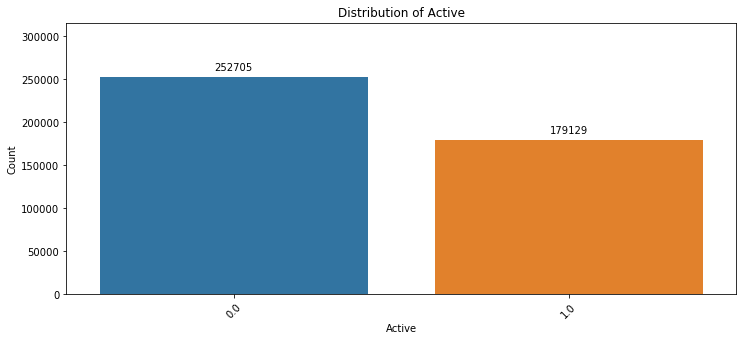

Plotting countplot...
Variable: Active
RFM Segment: Potential re-activation


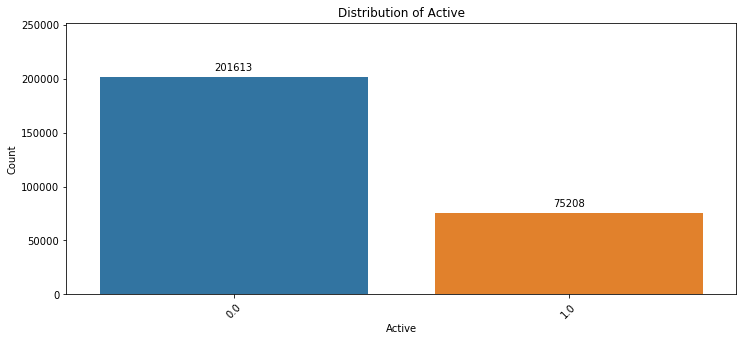

Plotting countplot...
Variable: Active
RFM Segment: Big spenders


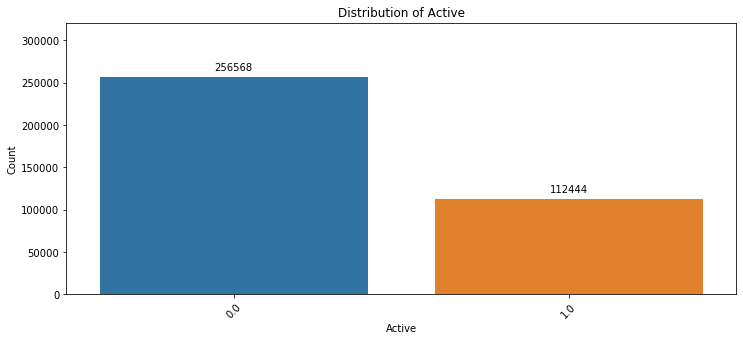

Plotting countplot...
Variable: Active
RFM Segment: Unprofitable


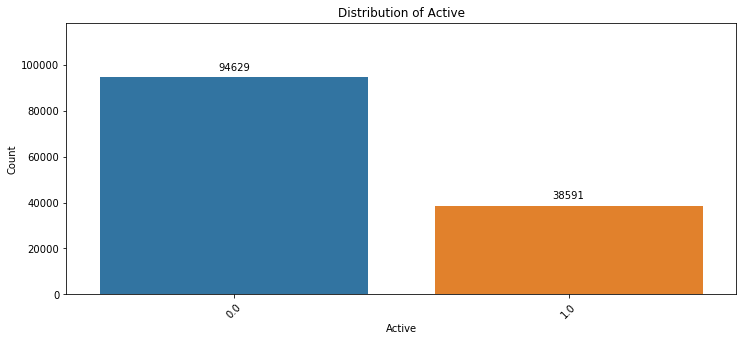

Plotting countplot...
Variable: Active
RFM Segment: Needs attention


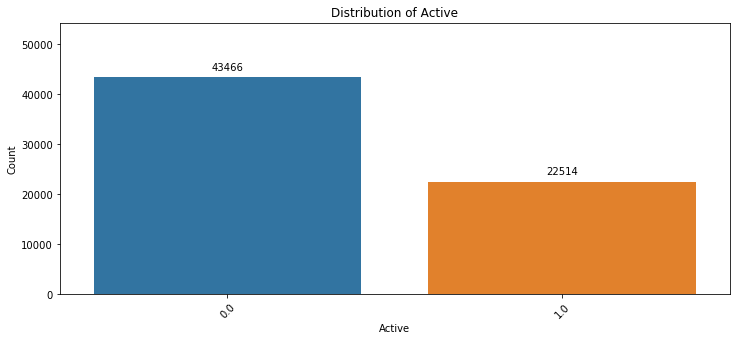

Plotting countplot...
Variable: Active
RFM Segment: Loyal


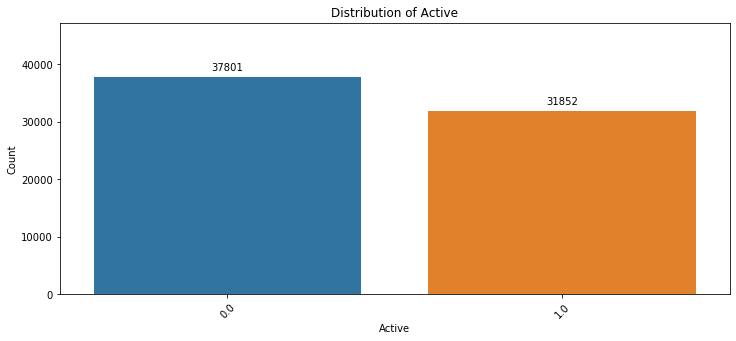

----- Variable: club_member_status -----
Plotting countplot...
Variable: club_member_status
RFM Segment: Champions


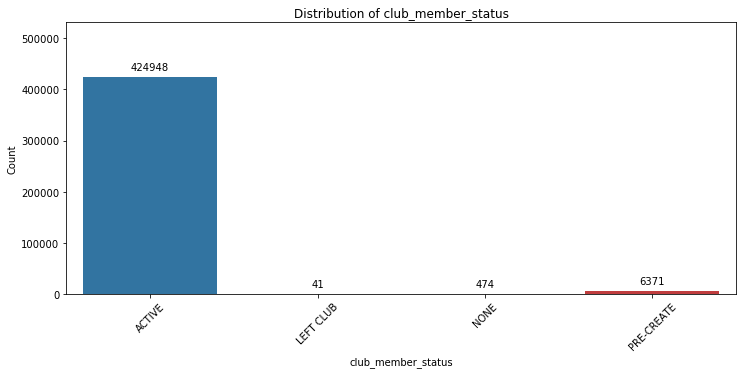

Plotting countplot...
Variable: club_member_status
RFM Segment: Potential re-activation


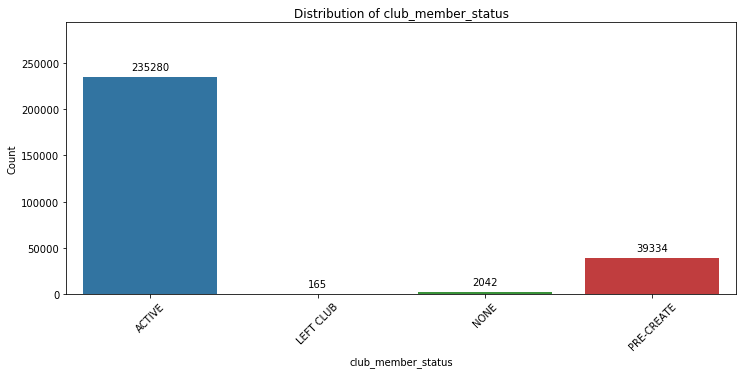

Plotting countplot...
Variable: club_member_status
RFM Segment: Big spenders


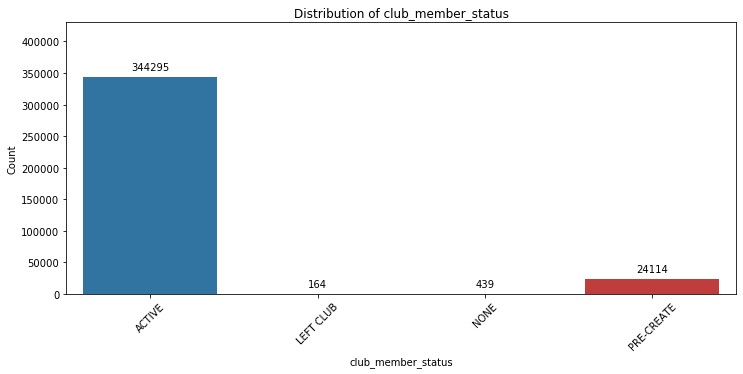

Plotting countplot...
Variable: club_member_status
RFM Segment: Unprofitable


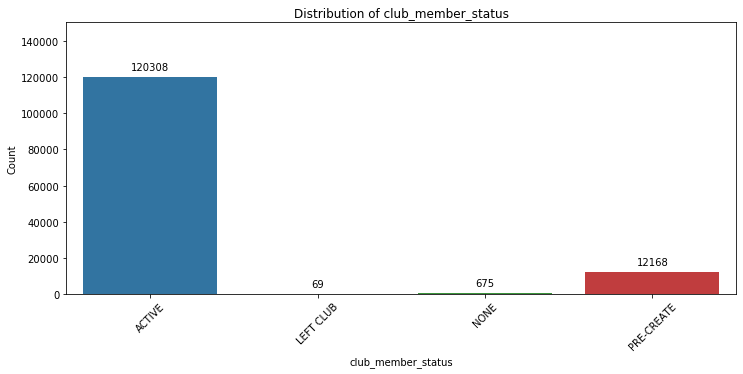

Plotting countplot...
Variable: club_member_status
RFM Segment: Needs attention


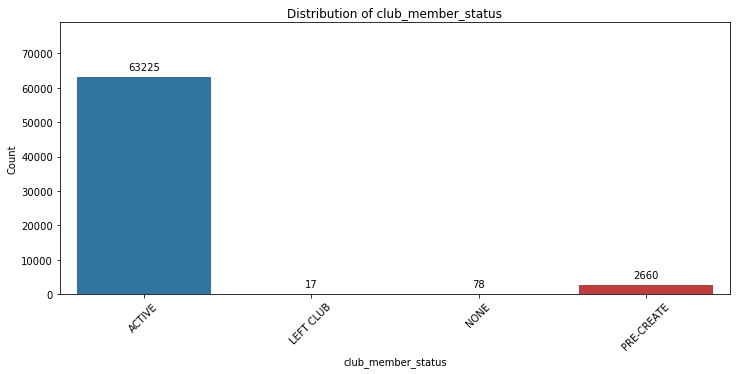

Plotting countplot...
Variable: club_member_status
RFM Segment: Loyal


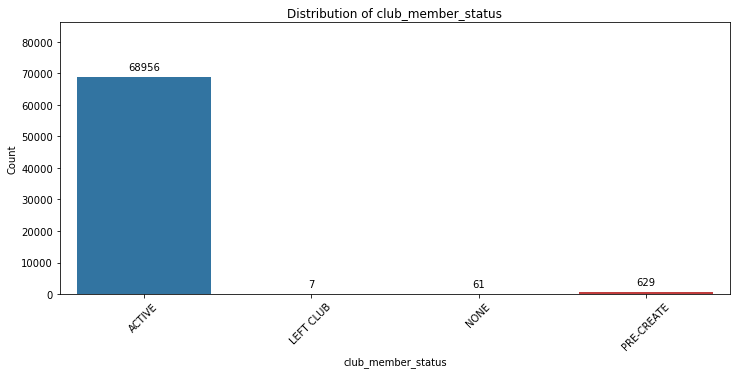

----- Variable: fashion_news_frequency -----
Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Champions


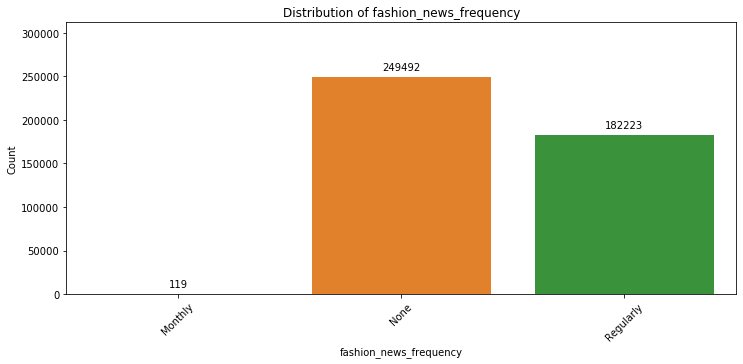

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Potential re-activation


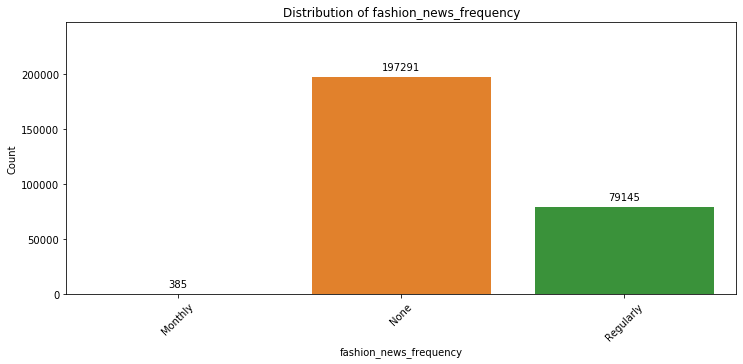

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Big spenders


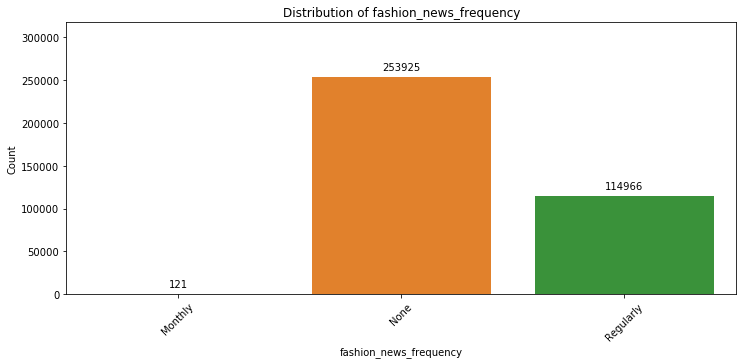

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Unprofitable


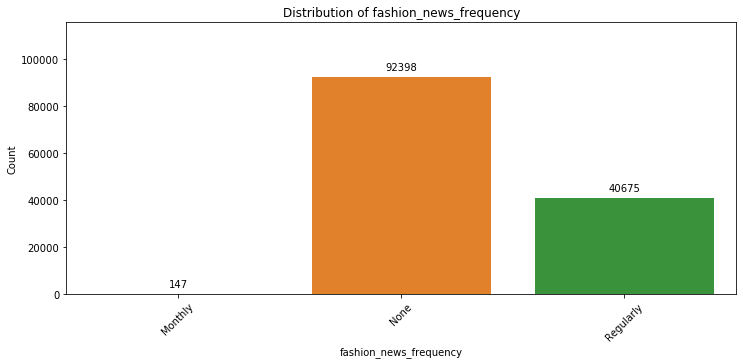

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Needs attention


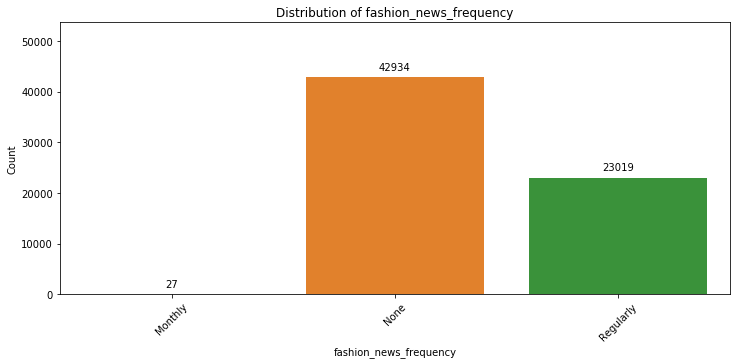

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Loyal


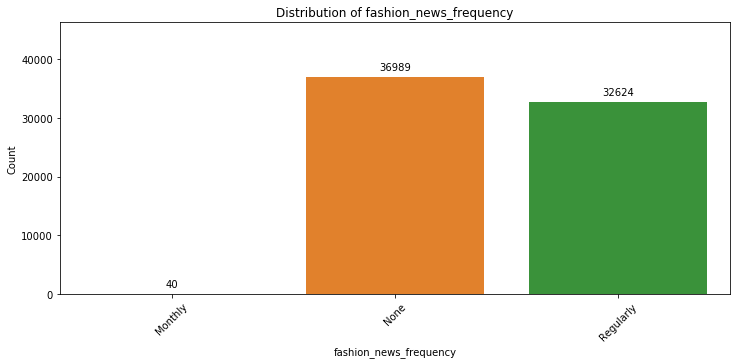

----- Variable: age -----
Plotting countplot...
Variable: age
RFM Segment: Champions


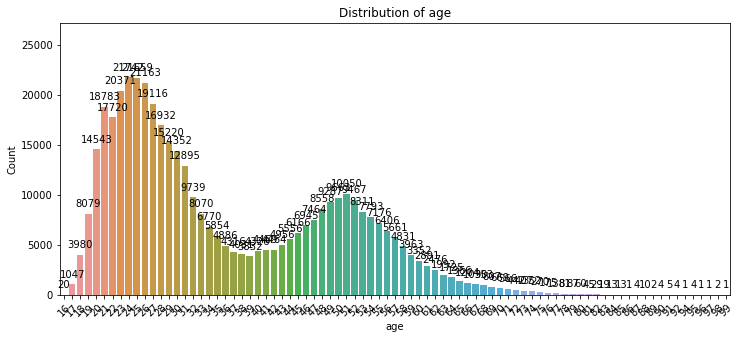

Plotting countplot...
Variable: age
RFM Segment: Potential re-activation


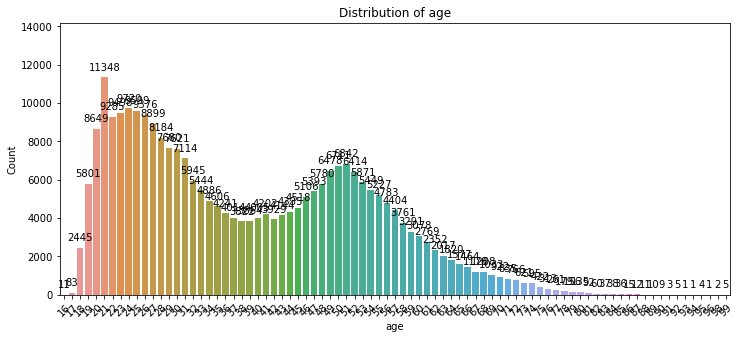

Plotting countplot...
Variable: age
RFM Segment: Big spenders


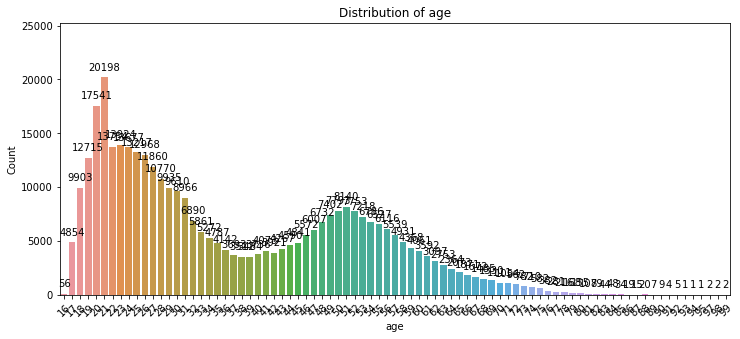

Plotting countplot...
Variable: age
RFM Segment: Unprofitable


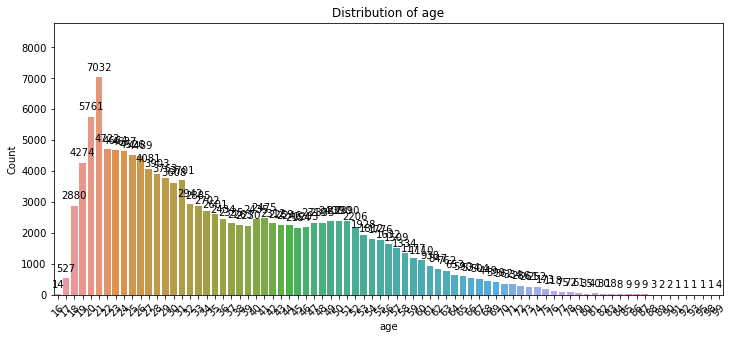

Plotting countplot...
Variable: age
RFM Segment: Needs attention


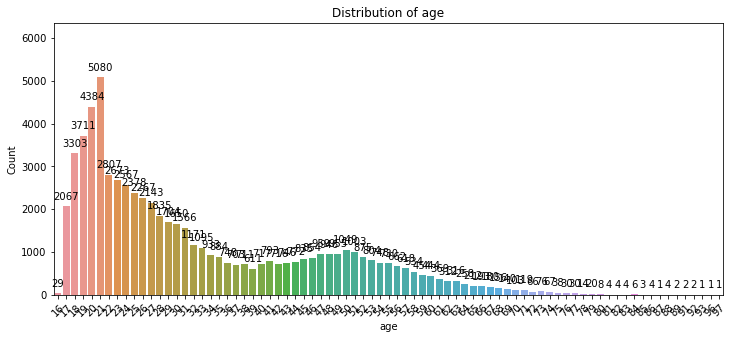

Plotting countplot...
Variable: age
RFM Segment: Loyal


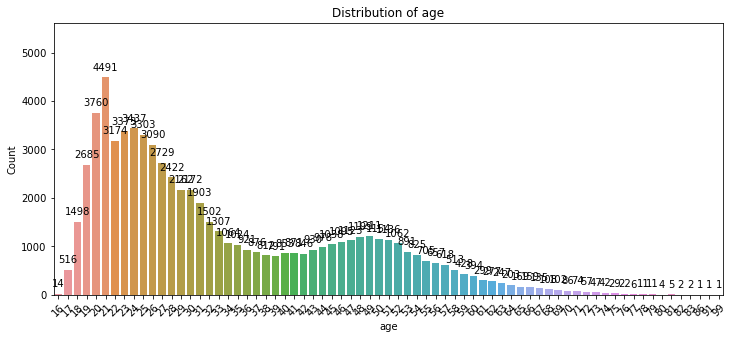

In [40]:
labels = list(rfm_customers['rfm_label'].unique())
for col in ['Active','club_member_status','fashion_news_frequency','age']:
    print('----- Variable:',col,'-----')
    for label in labels:
        subset_df = rfm_customers[rfm_customers['rfm_label']==label]
        print('Plotting countplot...')
        print('Variable:',col)
        print('RFM Segment:',label)
        sorted_x = list(subset_df[col].unique())
        sorted_x.sort()
        countplot(subset_df, col, sorted_x, rotate=True)

Demographic Analysis 2.2.2: Using pie charts (to better see the proportion) *excluded age variable here

----- Variable: Active -----


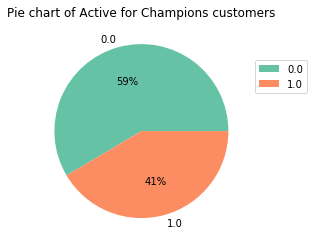

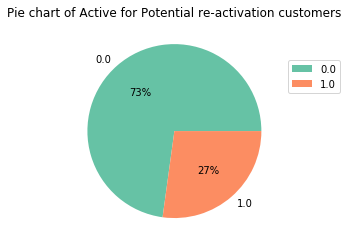

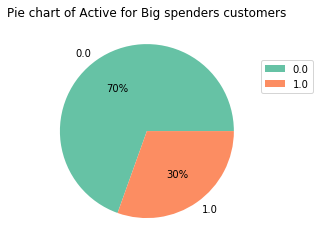

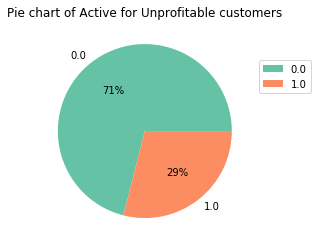

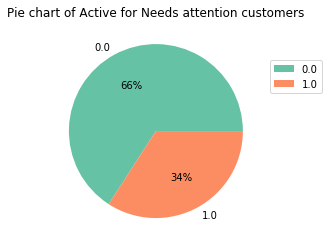

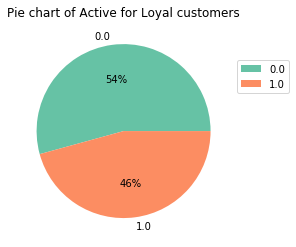

----- Variable: club_member_status -----


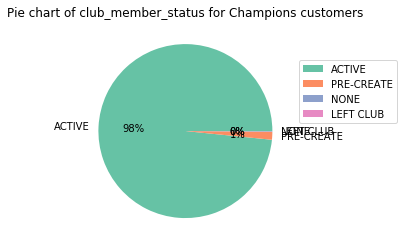

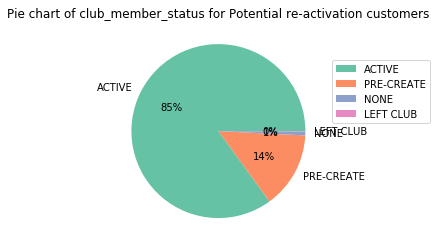

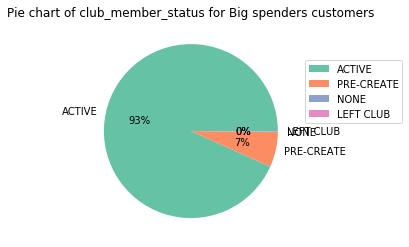

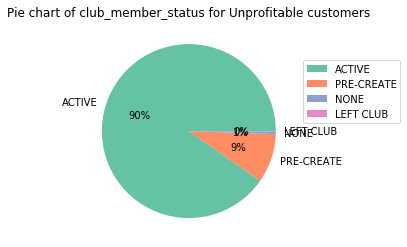

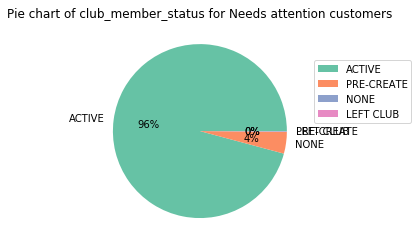

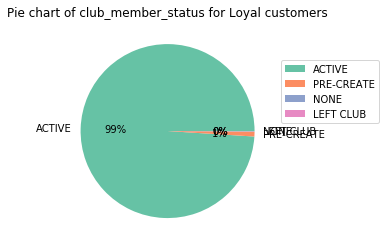

----- Variable: fashion_news_frequency -----


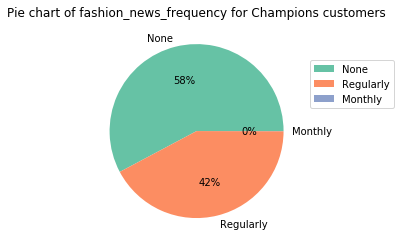

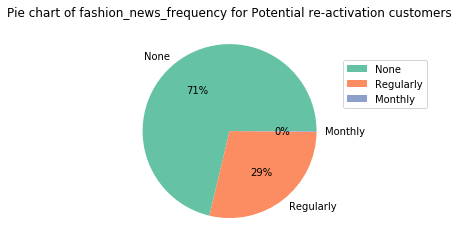

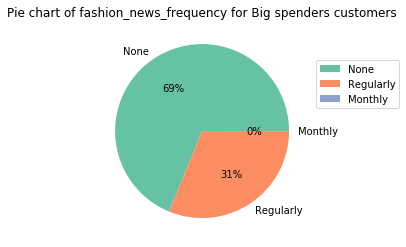

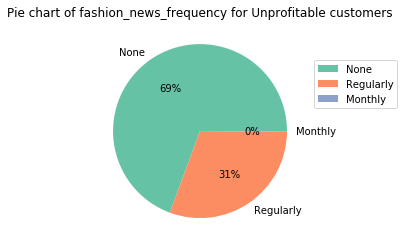

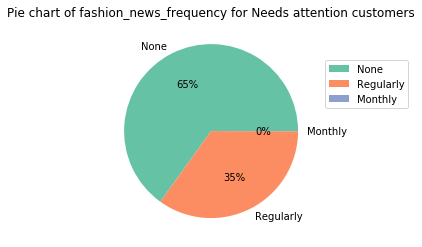

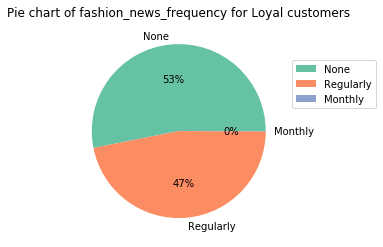

In [41]:
labels = list(rfm_customers['rfm_label'].unique())
for col in ['Active','club_member_status','fashion_news_frequency']:
    print('----- Variable:',col,'-----')
    for label in labels:
        subset_df = rfm_customers[rfm_customers['rfm_label']==label]
        colors = sns.color_palette('Set2')
        plt.pie(subset_df[col].value_counts(), labels=list(subset_df[col].unique()), colors=colors, autopct='%.0f%%')
        plt.title(f'Pie chart of {col} for {label} customers' )
        plt.legend(subset_df[col].value_counts().index, bbox_to_anchor = (1, 0.85))
        plt.show()

### 3.3.3 Purchase Behaviour Analysis of RFM Segments

#### Read in CSV and Conduct Basic Analysis

In [42]:
articles = pd.read_csv('data/articles.csv')
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [43]:
articles = articles.loc[:,['article_id','prod_name','product_type_name','product_group_name',
                          'graphical_appearance_name','colour_group_name','perceived_colour_value_name',
                          'perceived_colour_master_name','department_name','index_name','index_group_name',
                          'section_name','garment_group_name']]
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 13)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"


In [44]:
# Basic data check: Check for null values
for col in articles.columns:
    print("Number of Null Values in", col, " : ", len(articles[articles[col].isna()]), "/", len(articles))

Number of Null Values in article_id  :  0 / 105542
Number of Null Values in prod_name  :  0 / 105542
Number of Null Values in product_type_name  :  0 / 105542
Number of Null Values in product_group_name  :  0 / 105542
Number of Null Values in graphical_appearance_name  :  0 / 105542
Number of Null Values in colour_group_name  :  0 / 105542
Number of Null Values in perceived_colour_value_name  :  0 / 105542
Number of Null Values in perceived_colour_master_name  :  0 / 105542
Number of Null Values in department_name  :  0 / 105542
Number of Null Values in index_name  :  0 / 105542
Number of Null Values in index_group_name  :  0 / 105542
Number of Null Values in section_name  :  0 / 105542
Number of Null Values in garment_group_name  :  0 / 105542


In [45]:
# Convert datatypes to suitable datatypes
articles = articles.astype({'article_id':'str',
                            'prod_name':'category',
                            'product_type_name':'category',
                            'product_group_name':'category',
                            'graphical_appearance_name':'category',
                            'colour_group_name':'category',
                            'perceived_colour_value_name':'category',
                            'perceived_colour_master_name':'category',
                            'department_name':'category',
                            'index_name':'category',
                            'index_group_name':'category',
                            'section_name':'category',
                            'garment_group_name':'category'})
articles.dtypes

article_id                        object
prod_name                       category
product_type_name               category
product_group_name              category
graphical_appearance_name       category
colour_group_name               category
perceived_colour_value_name     category
perceived_colour_master_name    category
department_name                 category
index_name                      category
index_group_name                category
section_name                    category
garment_group_name              category
dtype: object

In [46]:
# Merge Articles with Transaction Data on article_id (Transations data is df_new subsetted at the start)
article_transaction = articles.merge(df_new, on='article_id')

# Merge Article+Transaction with RFM Data on customer_id
rfm_article_transact = article_transaction.merge(df_rfm[['customer_id','Recency','Frequency','Monetary','rfm_label']], on='customer_id')

print('Dataframe shape:',rfm_article_transact.shape)
rfm_article_transact.head()

Dataframe shape: (31788324, 20)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,customer_id,t_dat,price,Recency,Frequency,Monetary,rfm_label
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2018-09-20,0.008458,14,89,0.026006,Champions
1,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2018-09-20,0.008458,14,89,0.026006,Champions
2,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2018-12-04,0.008458,14,89,0.026006,Champions
3,237347040,Theron,Hoodie,Garment Upper body,Melange,Light Blue,Light,Blue,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2019-04-08,0.033881,14,89,0.026006,Champions
4,270381001,Clubba sunglasses,Sunglasses,Accessories,Solid,Yellowish Brown,Dark,Brown,Sunglasses,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2019-07-12,0.006763,14,89,0.026006,Champions


#### Remove irrelevant columns and put customer_id to the front of the dataframe

In [47]:
# Drop columns that are not needed
rfm_article_transact = rfm_article_transact.drop(['article_id','t_dat','Recency','Frequency','Monetary'], axis=1)

# Place customer_id in the 1st column
customer_id = rfm_article_transact['customer_id']
rfm_article_transact.drop(labels=['customer_id'], axis=1, inplace=True)
rfm_article_transact.insert(0, 'customer_id', customer_id)

rfm_article_transact.head()

,customer_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,price,rfm_label
0,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,Champions
1,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,Champions
2,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,Champions
3,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Theron,Hoodie,Garment Upper body,Melange,Light Blue,Light,Blue,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.033881,Champions
4,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Clubba sunglasses,Sunglasses,Accessories,Solid,Yellowish Brown,Dark,Brown,Sunglasses,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,0.006763,Champions


#### Purchase Behaviour Analysis 1: Descriptive analysis

In [48]:
rfm_article_transact.groupby('rfm_label')['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
               'perceived_colour_value_name','perceived_colour_master_name','department_name',
               'index_name','index_group_name','section_name','garment_group_name'].describe()

prod_name                                           \
                            count unique                       top    freq   
rfm_label                                                                    
Big spenders              3484067  37906  Jade HW Skinny Denim TRS   26421   
Champions                22391844  44292  Jade HW Skinny Denim TRS  123255   
Loyal                     2648145  36289                 Tilly (1)   15919   
Needs attention            599031  25780                 Tilly (1)    5373   
Potential re-activation   1885133  27525            Luna skinny RW   10726   
Unprofitable               780104  24703                 Tilly (1)    4619   

                        product_type_name                            \
                                    count unique       top     freq   
rfm_label                                                             
Big spenders                      3484067    126  Trousers   516858   
Champions                        22391844    130  Trousers  3032623   
Loyal                             2648145    128   T-shirt   275561   
Needs attention                    599031    119   T-shirt    72816   
Potential re-activation           1885133    112  Trousers   293010   
Unprofitable                       780104    115   T-shirt    98959   

                        graphical_appearance_name                          \
                                            count unique    top      freq   
rfm_label                                                                   
Big spenders                              3484067     30  Solid   1950716   
Champions                                22391844     30  Solid  12739490   
Loyal                                     2648145     30  Solid   1444982   
Needs attention                            599031     30  Solid    338149   
Potential re-activation                   1885133     29  Solid    980109   
Unprofitable                               780104     29  Solid    396485   

                        colour_group_name                         \
                                    count unique    top     freq   
rfm_label                                                          
Big spenders                      3484067     50  Black  1264320   
Champions                        22391844     50  Black  7803587   
Loyal                             2648145     50  Black   868186   
Needs attention                    599031     50  Black   206748   
Potential re-activation           1885133     50  Black   649887   
Unprofitable                       780104     50  Black   244228   

                        perceived_colour_value_name                         \
                                              count unique   top      freq   
rfm_label                                                                    
Big spenders                                3484067      8  Dark   1792109   
Champions                                  22391844      8  Dark  10922094   
Loyal                                       2648145      8  Dark   1234202   
Needs attention                              599031      8  Dark    286299   
Potential re-activation                     1885133      8  Dark    982435   
Unprofitable                                 780104      8  Dark    372424   

                        perceived_colour_master_name                         \
                                               count unique    top     freq   
rfm_label                                                                     
Big spenders                                 3484067     20  Black  1256689   
Champions                                   22391844     20  Black  7753929   
Loyal                                        2648145     20  Black   862146   
Needs attention                               599031     20  Black   205616   
Potential re-activation                      1885133     20  Black   641945   
Unprofitable                           

#### Purchase Behaviour Analysis 2: Analysis of purchase behaviour by segments (Bottom 2 analyses are the same just displayed in different sequences)

#### - Purchase Behaviour Analysis 2.1: Compare purchase behaviour within RFM segments (Same as Graphical Analysis but in number form)

In [49]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#     for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name']:
#         print('Column:',col)
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0]
#         if len(value_counts) > 10:
#             print(value_counts[:10])
#         else:
#             print(value_counts)
#         print('\n')

#### - Purchase Behaviour Analysis 2.2: Compare purchase behaviour across RFM segments (Same as Graphical Analysis but in number form)

In [50]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name']:
#     print('----- Column:',col,'-----')
#     for label in labels:
#         print('RFM Segment:',label)
#         subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0]
#         if len(value_counts) > 10:
#             print(value_counts[:10])
#         else:
#             print(value_counts)
#         print('\n')

#### Purchase Behaviour Analysis 3: Graphical Analysis for the different RFM Segments (Bottom 2 analyses are the same just displayed in different sequences)

In [51]:
def barplot(df, segment, var_col, xticklabels, rotate=False):
    fig, ax = plt.subplots(figsize=(15,7))
    plt.bar(xticklabels, df[var_col])
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

    ax.set_xticklabels(xticklabels)
    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])    
    plt.ylim(0, max_height*1.25)
    plt.title(f'Bar chart of {var_col} for {segment}')
    plt.show()

#### - Purchase Behaviour Analysis 3.1: View graphs by RFM Segments (Compare within RFM Segments) [Based on Top 10 categories]

In [52]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#     for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name']:
#         print('Column:',col)
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0].to_frame()
#         if len(value_counts) > 10:
#             value_counts = value_counts[:10]
#         barplot(value_counts, label, col, value_counts.index, rotate=True)
#         print('\n')

#### - Purchase Behaviour Analysis 3.2: View graphs by Variables (Compare across RFM Segments)

----- Variable: prod_name -----
RFM Segment: Champions


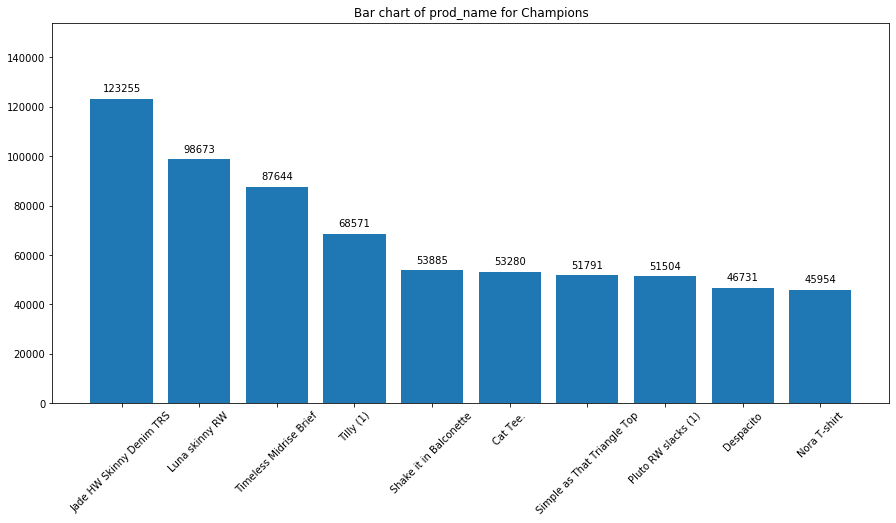



RFM Segment: Big spenders


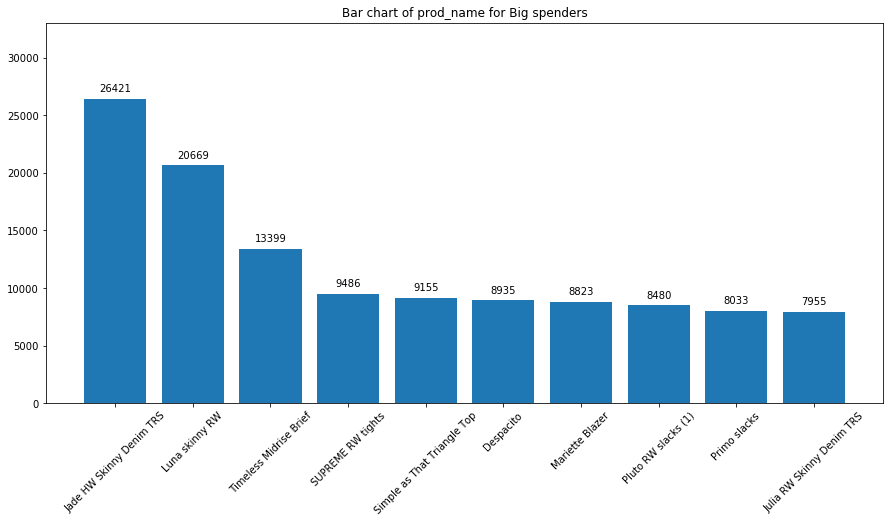



RFM Segment: Loyal


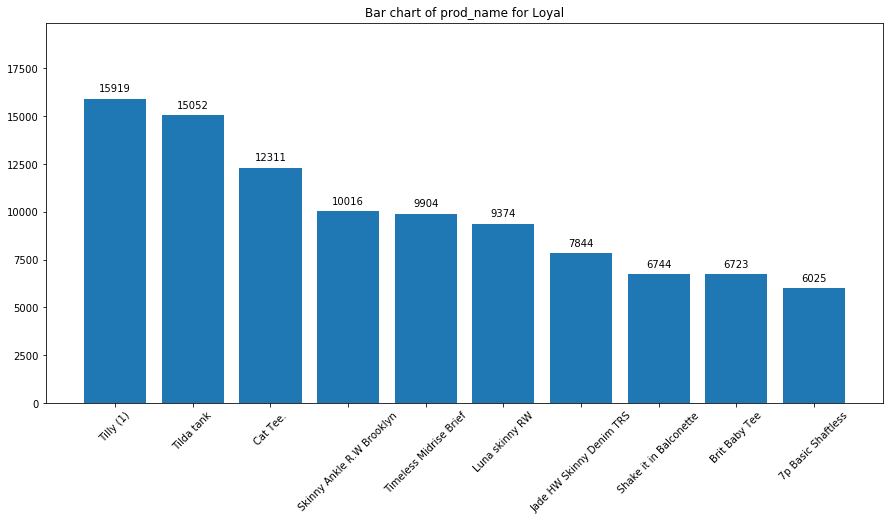



RFM Segment: Potential re-activation


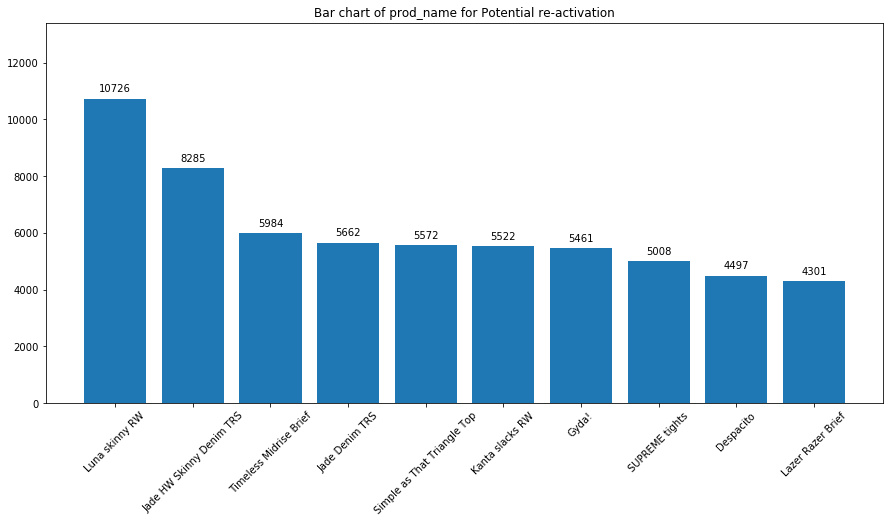



RFM Segment: Needs attention


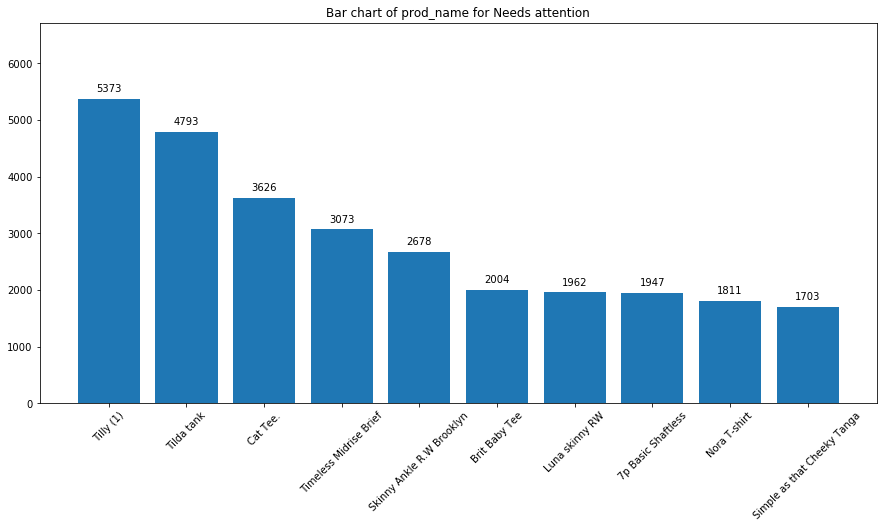



RFM Segment: Unprofitable


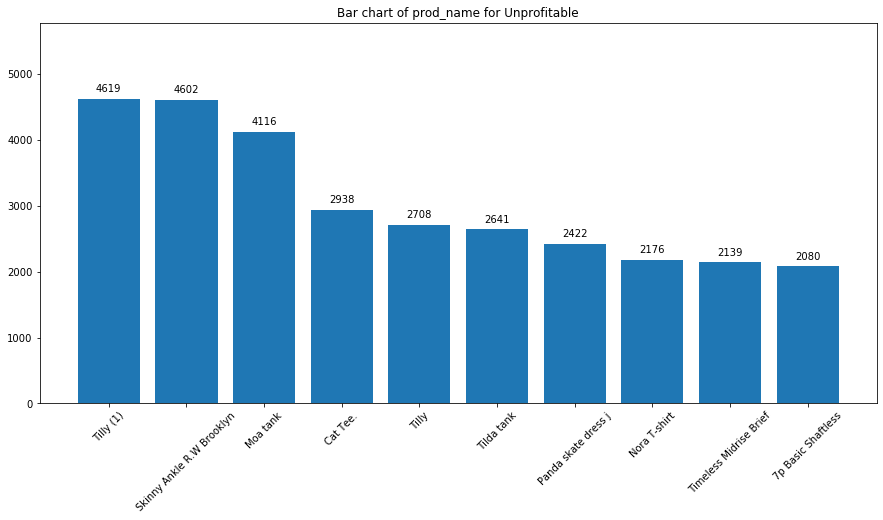



----- Variable: product_type_name -----
RFM Segment: Champions


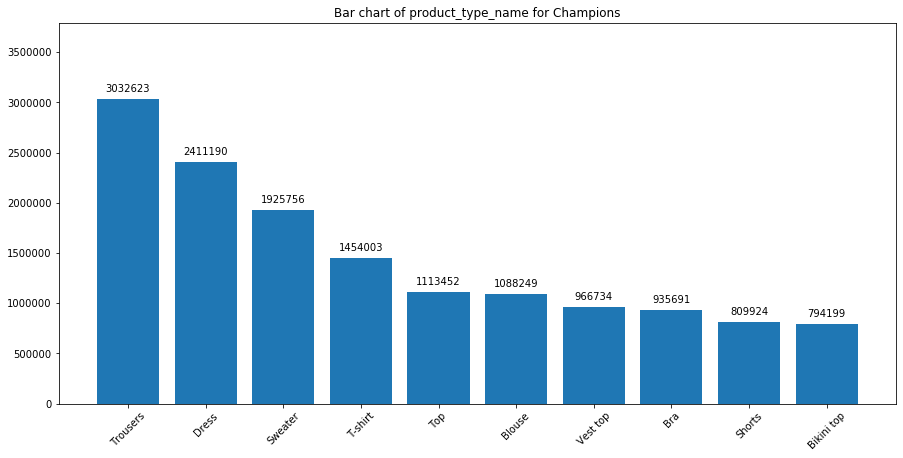



RFM Segment: Big spenders


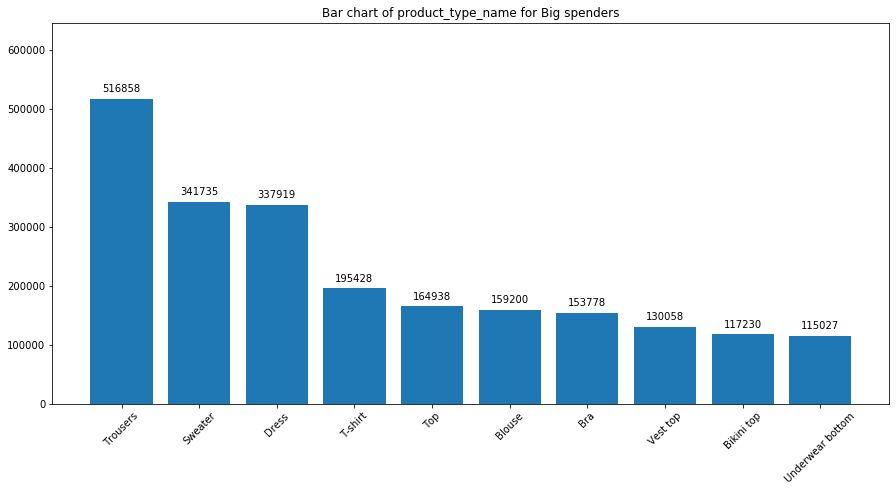



RFM Segment: Loyal


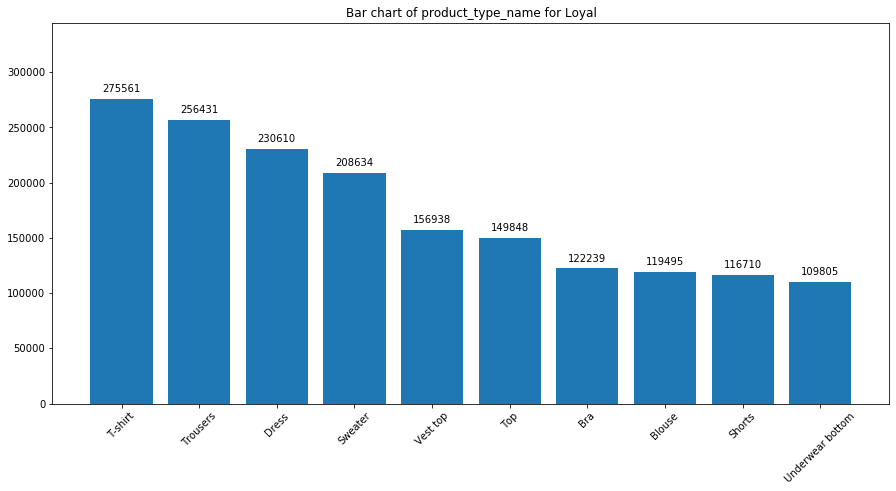



RFM Segment: Potential re-activation


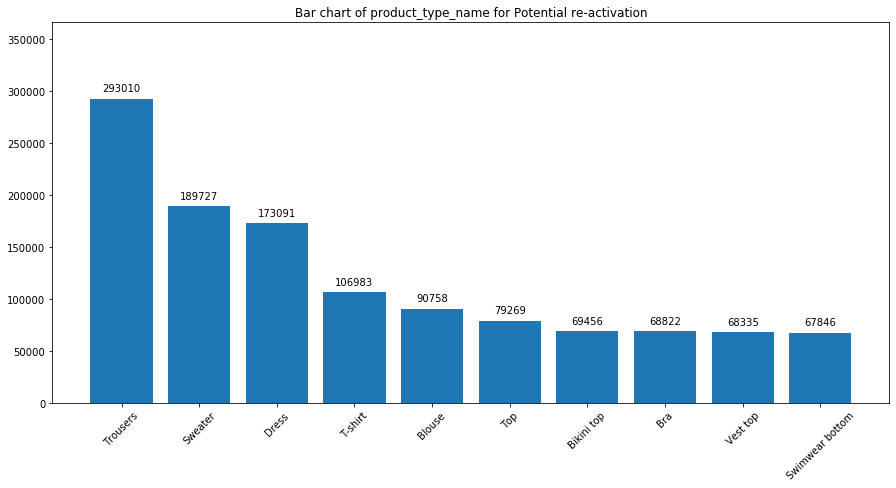



RFM Segment: Needs attention


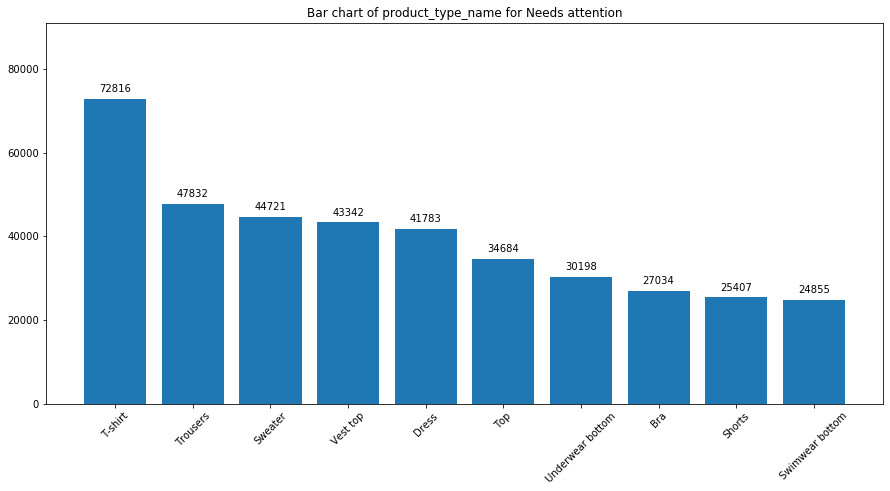



RFM Segment: Unprofitable


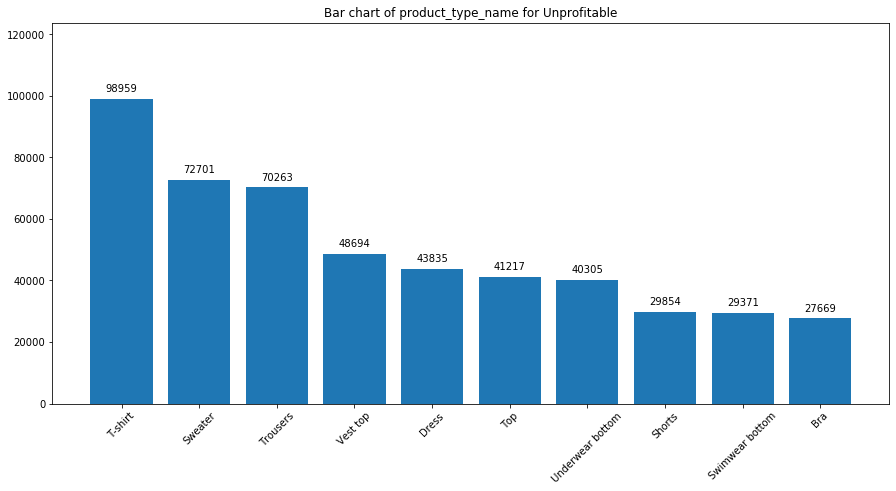



----- Variable: graphical_appearance_name -----
RFM Segment: Champions


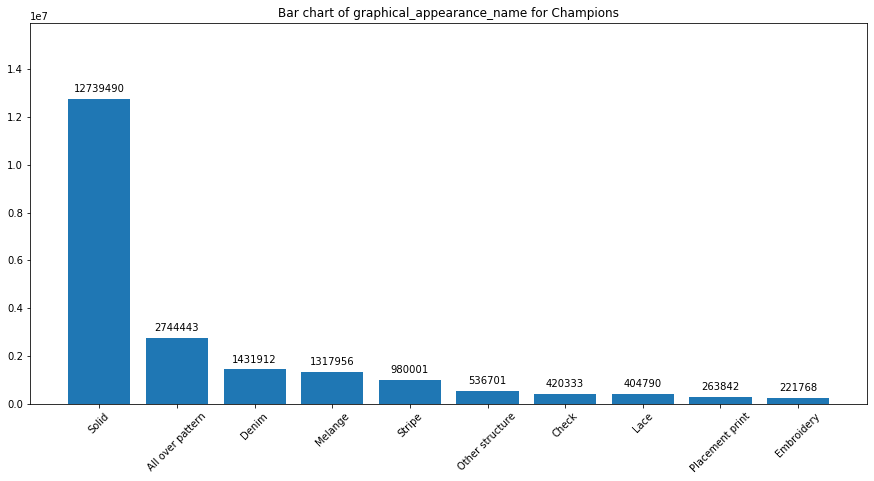



RFM Segment: Big spenders


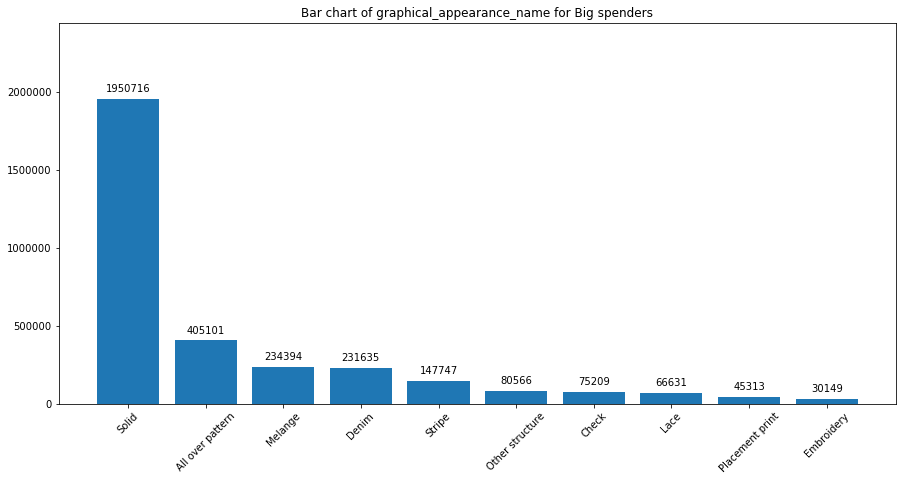



RFM Segment: Loyal


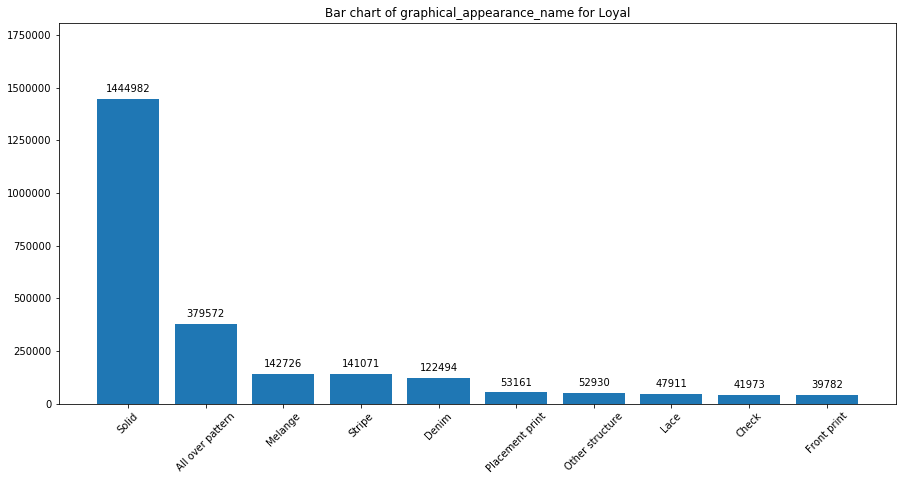



RFM Segment: Potential re-activation


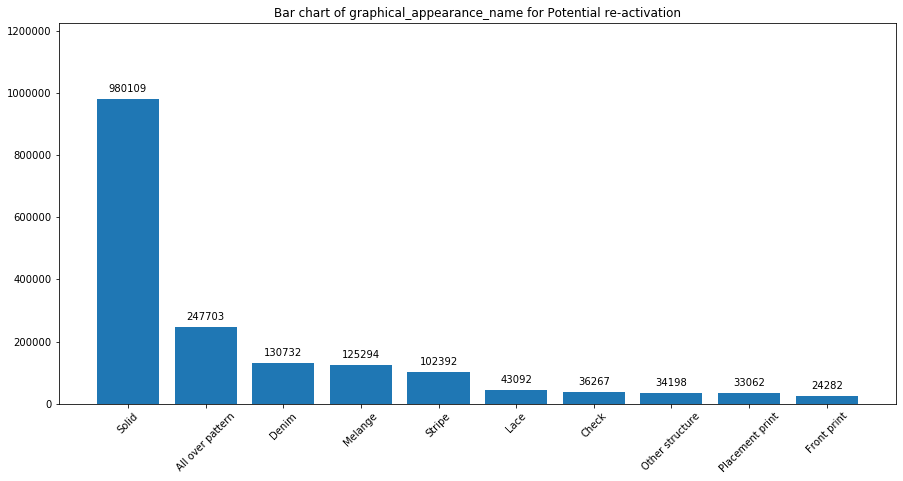



RFM Segment: Needs attention


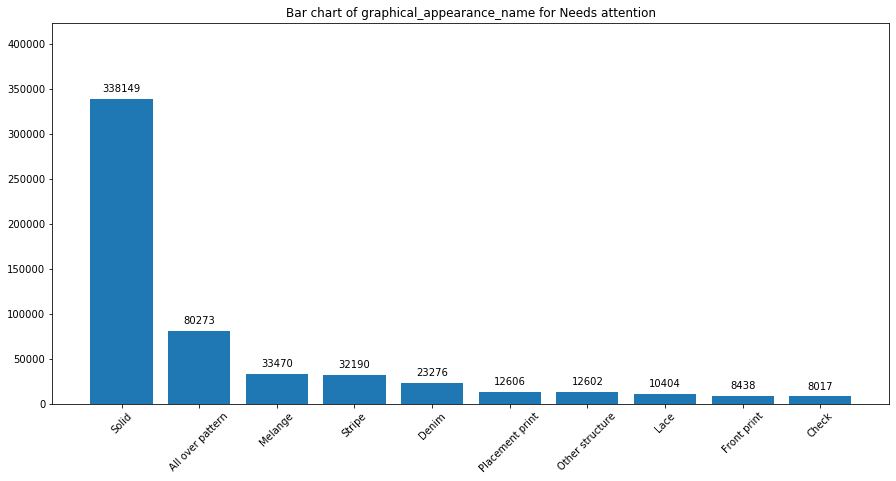



RFM Segment: Unprofitable


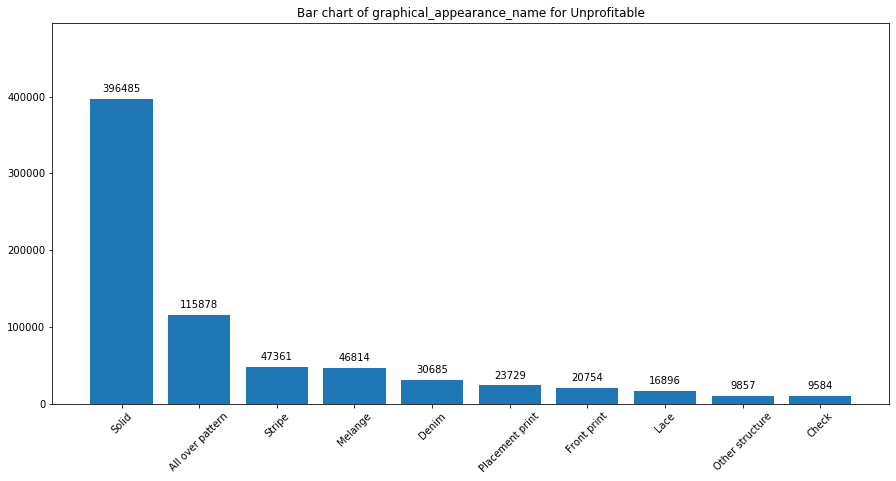



----- Variable: colour_group_name -----
RFM Segment: Champions


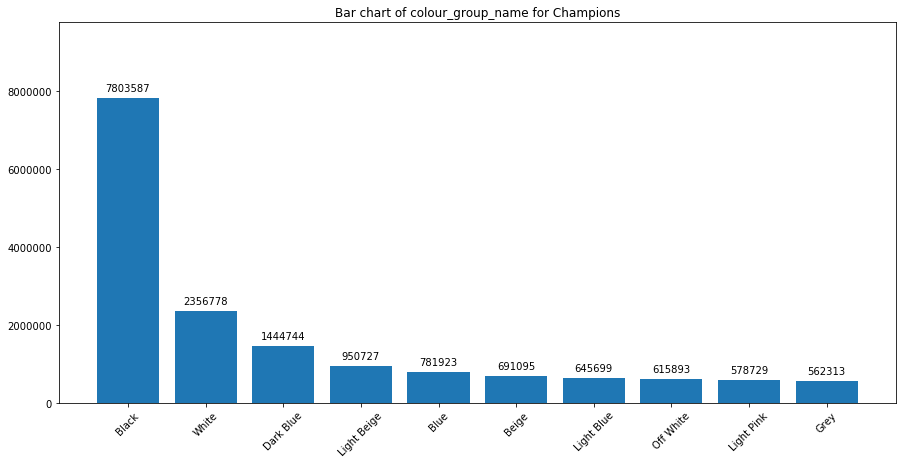



RFM Segment: Big spenders


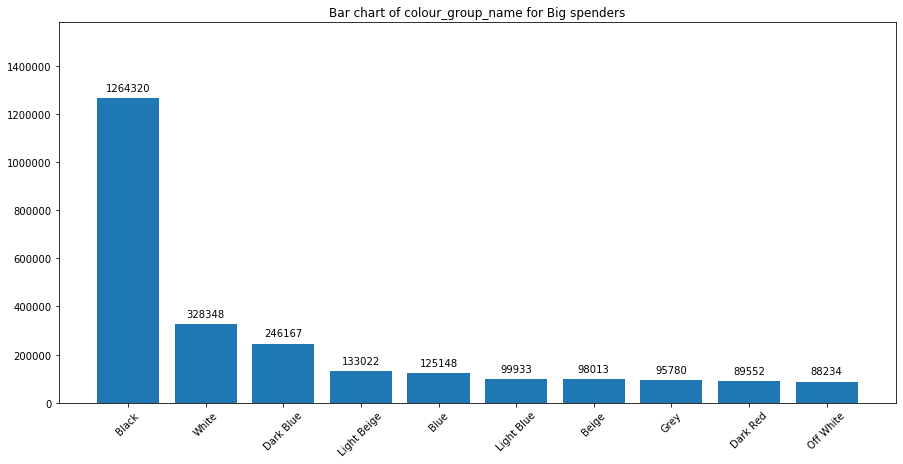



RFM Segment: Loyal


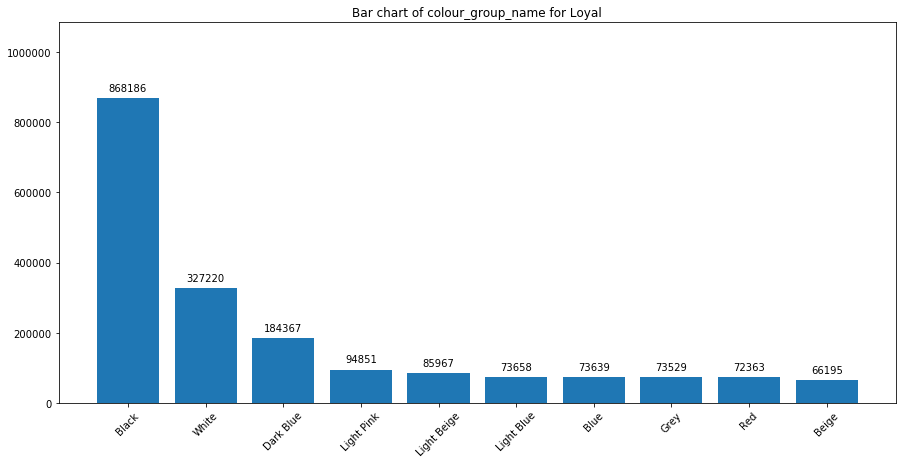



RFM Segment: Potential re-activation


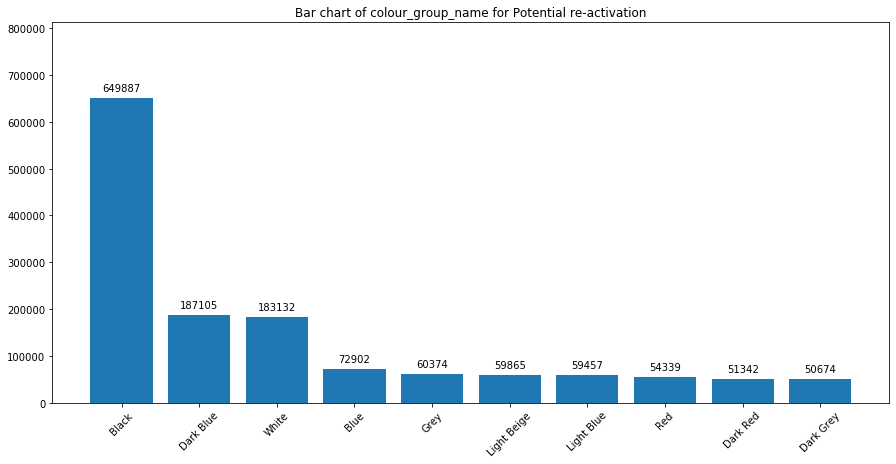



RFM Segment: Needs attention


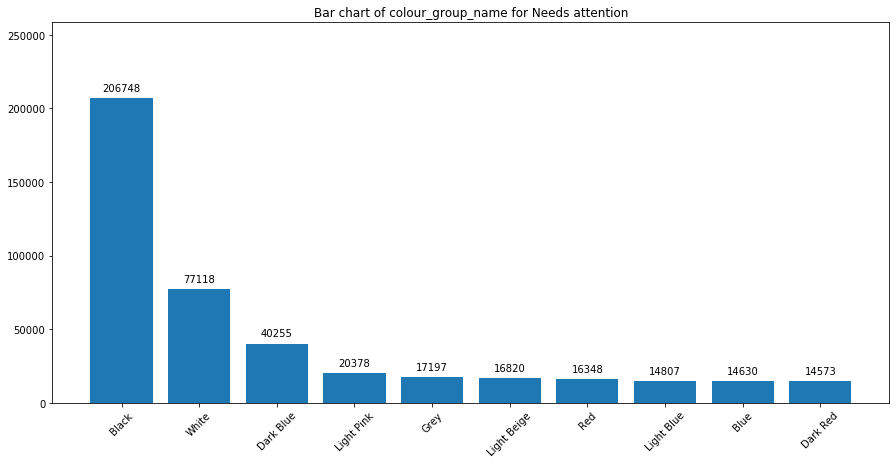



RFM Segment: Unprofitable


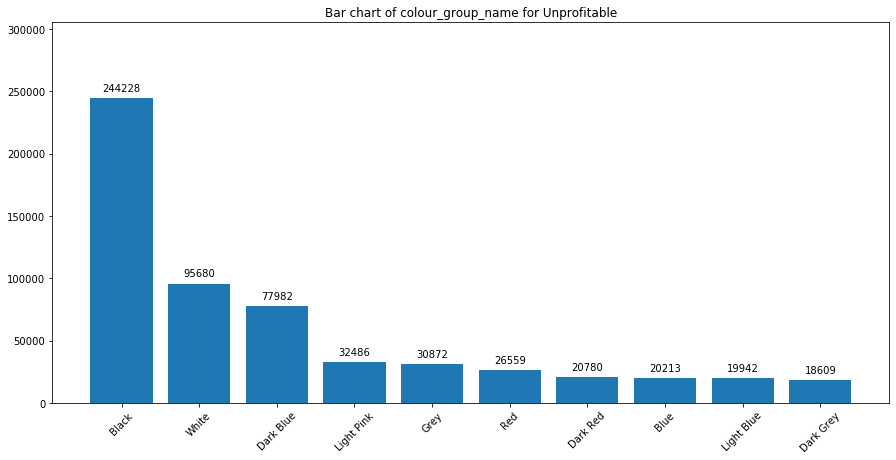



----- Variable: perceived_colour_value_name -----
RFM Segment: Champions


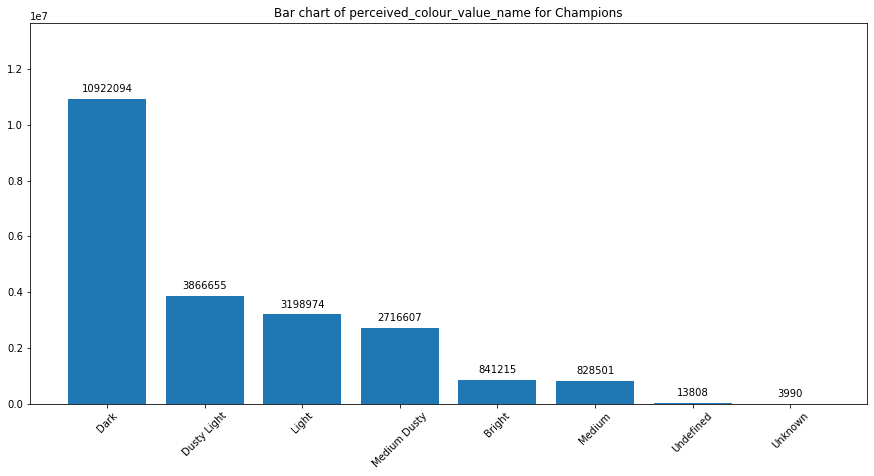



RFM Segment: Big spenders


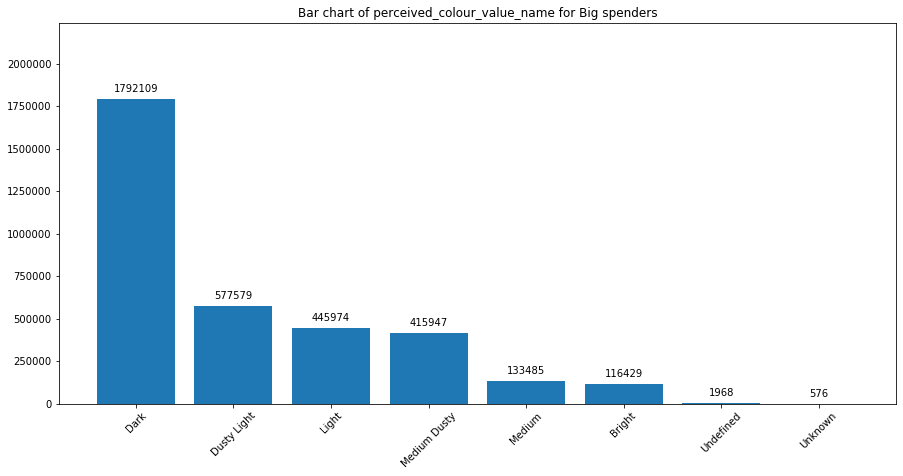



RFM Segment: Loyal


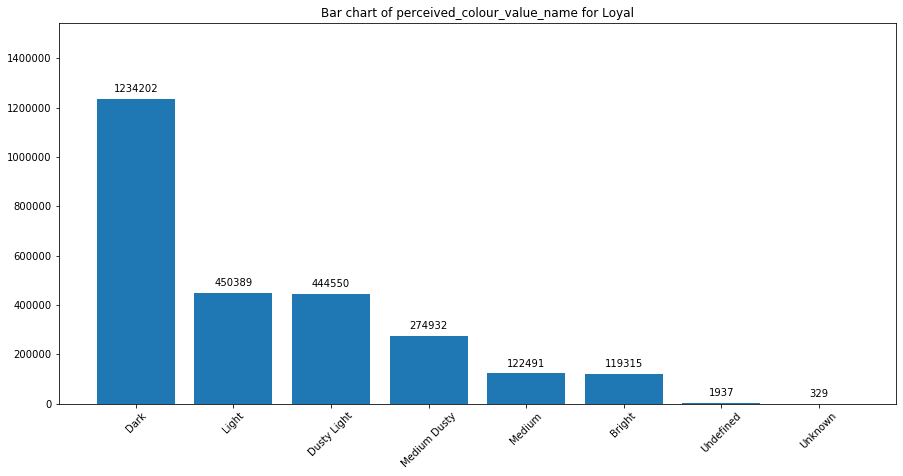



RFM Segment: Potential re-activation


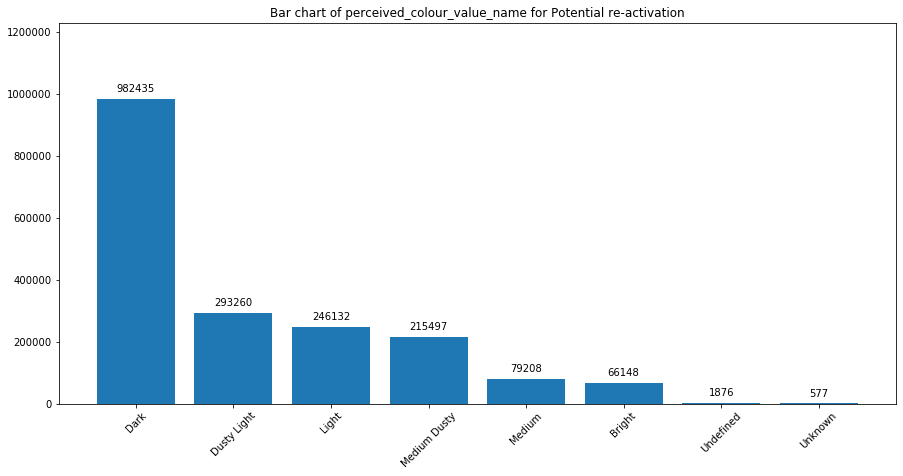



RFM Segment: Needs attention


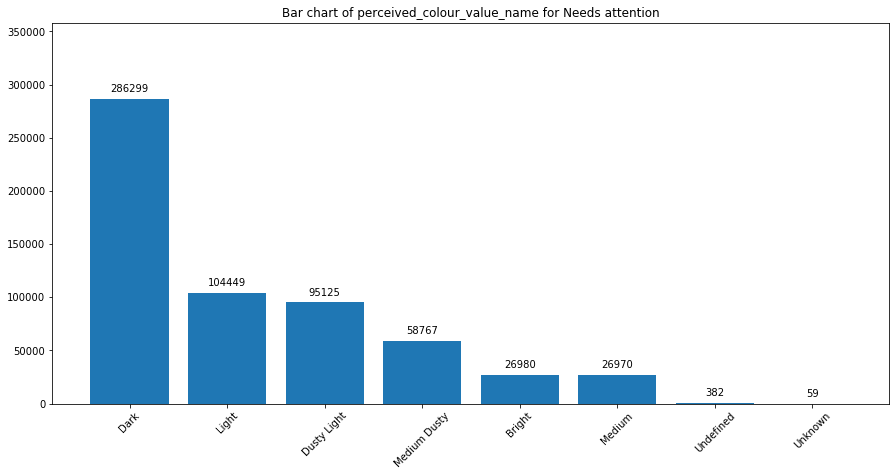



RFM Segment: Unprofitable


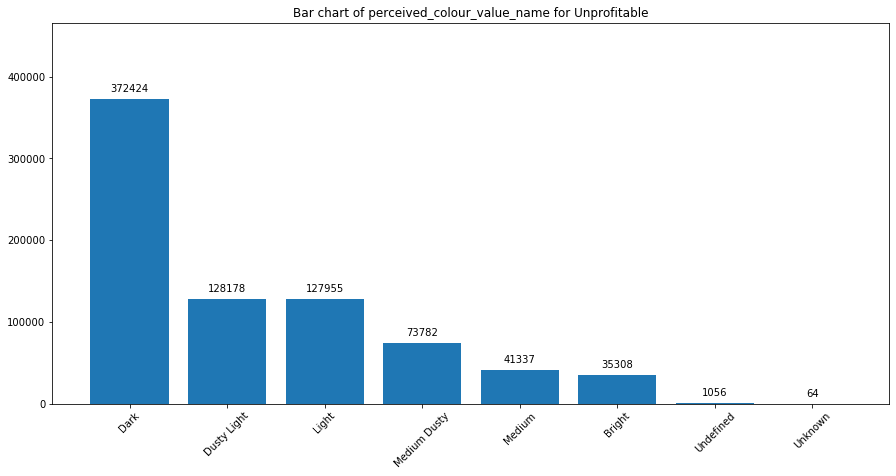



----- Variable: perceived_colour_master_name -----
RFM Segment: Champions


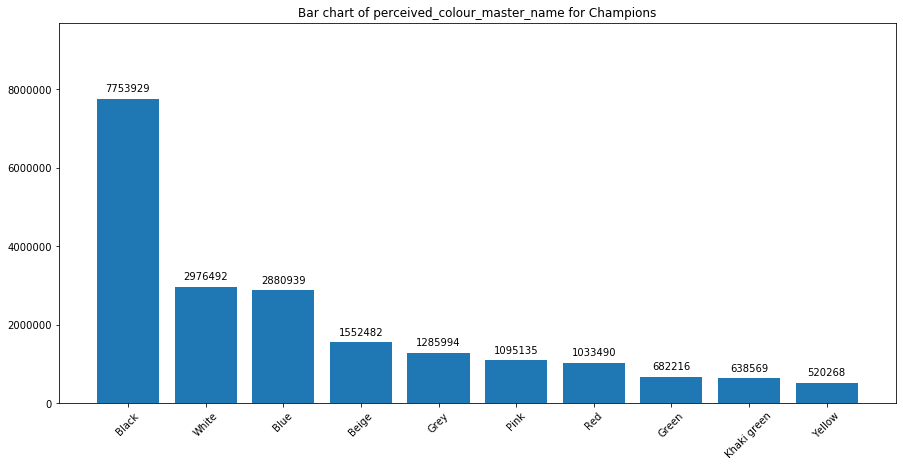



RFM Segment: Big spenders


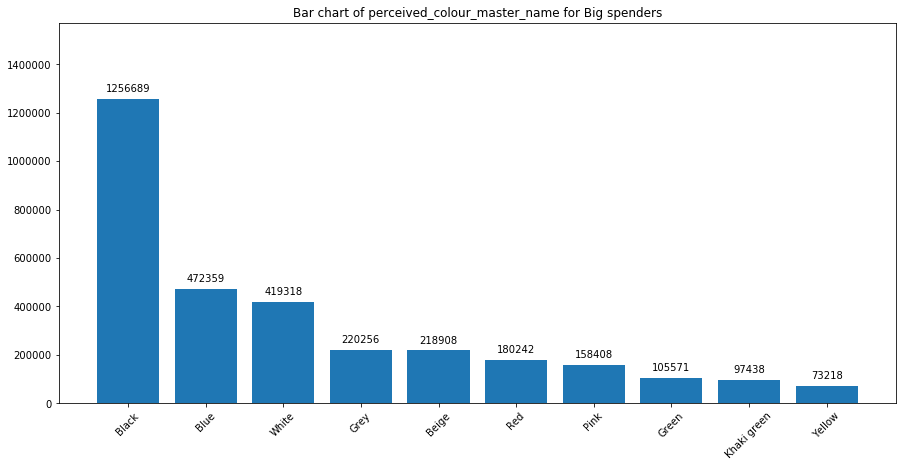



RFM Segment: Loyal


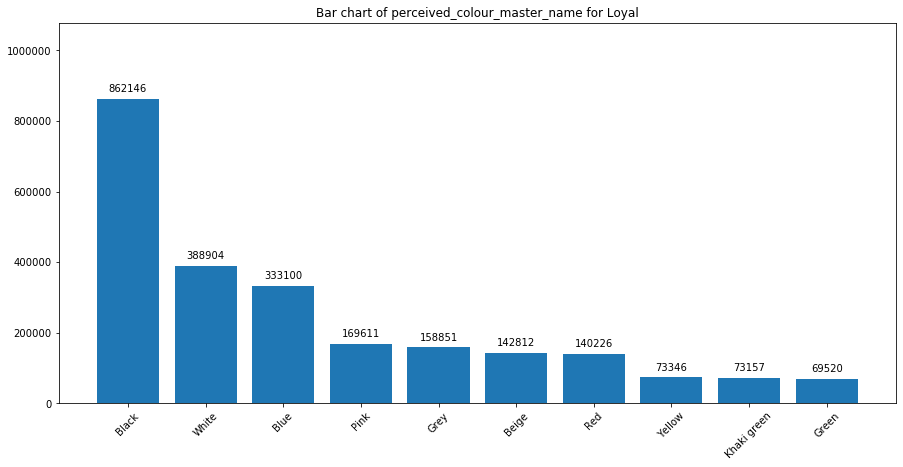



RFM Segment: Potential re-activation


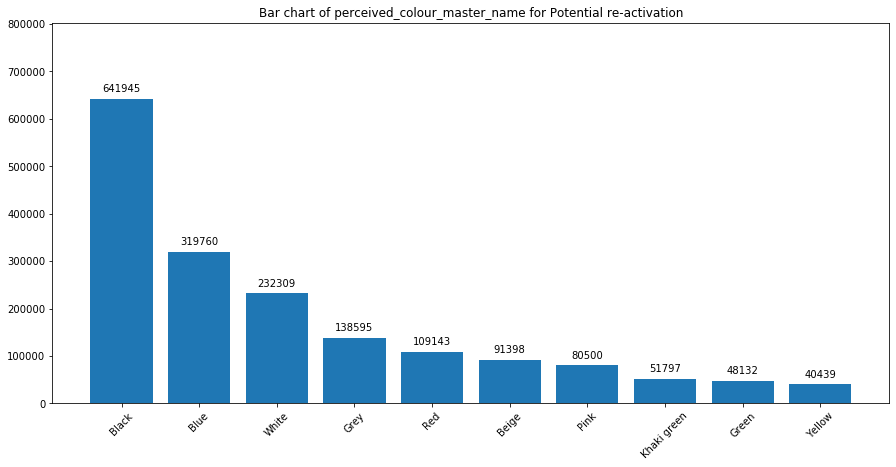



RFM Segment: Needs attention


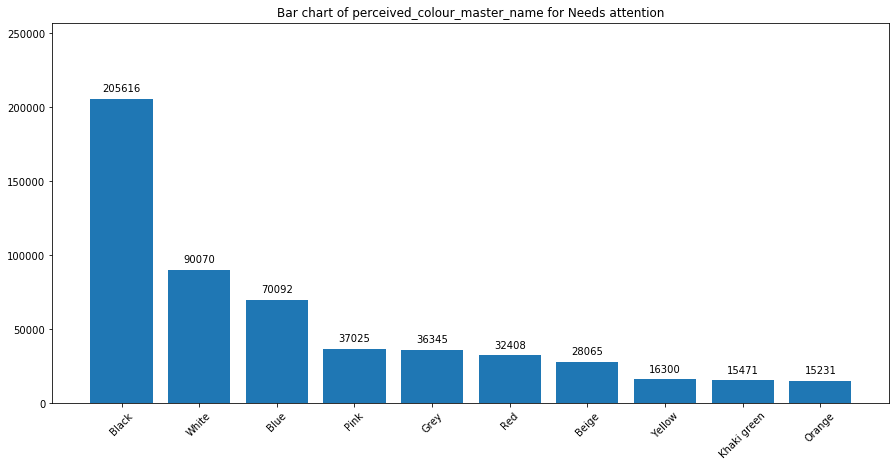



RFM Segment: Unprofitable


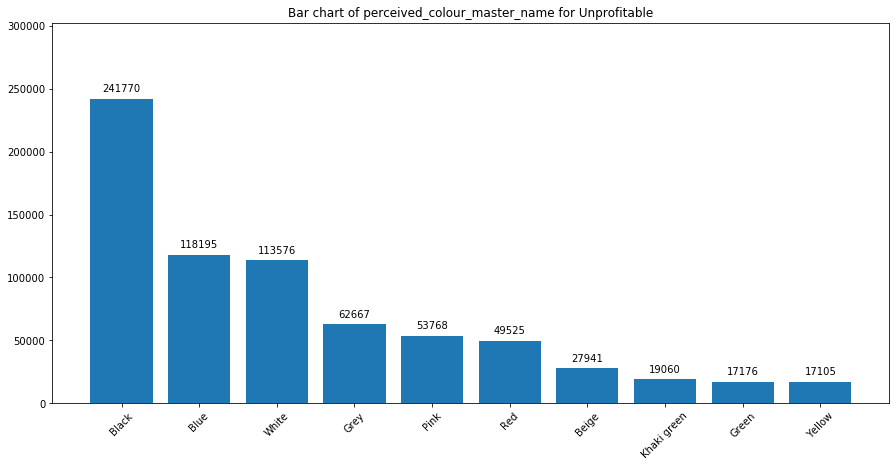



----- Variable: department_name -----
RFM Segment: Champions


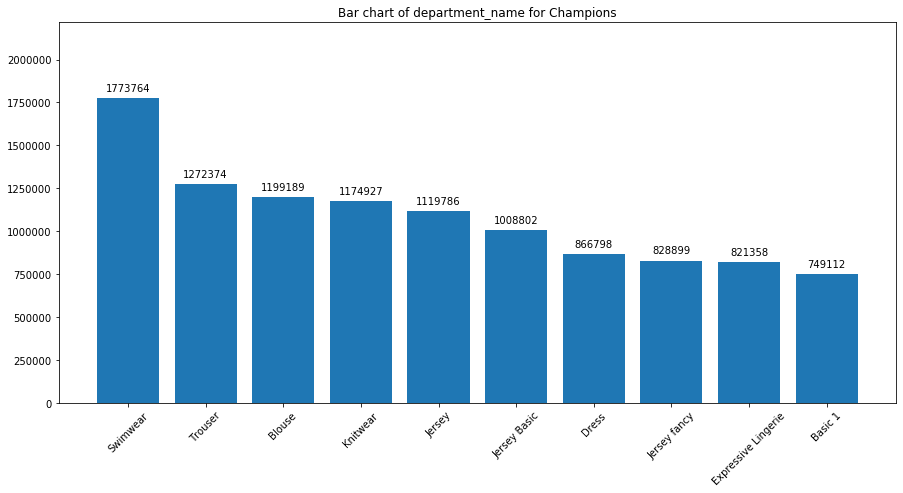



RFM Segment: Big spenders


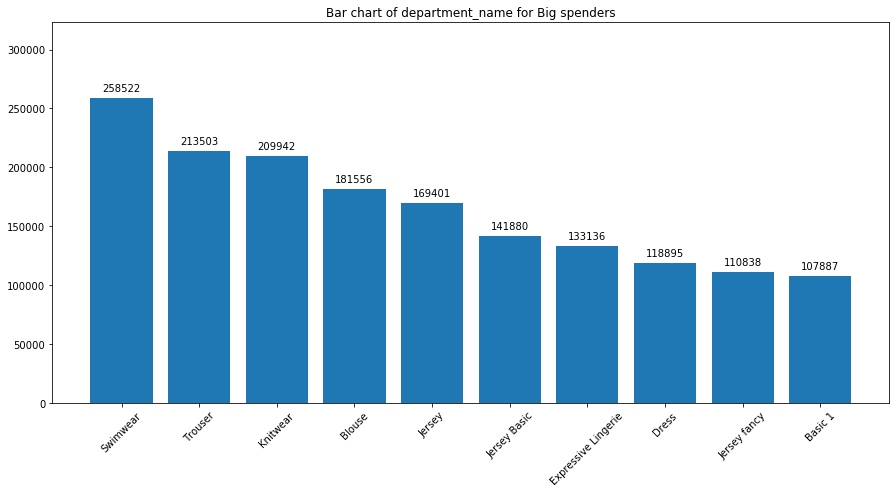



RFM Segment: Loyal


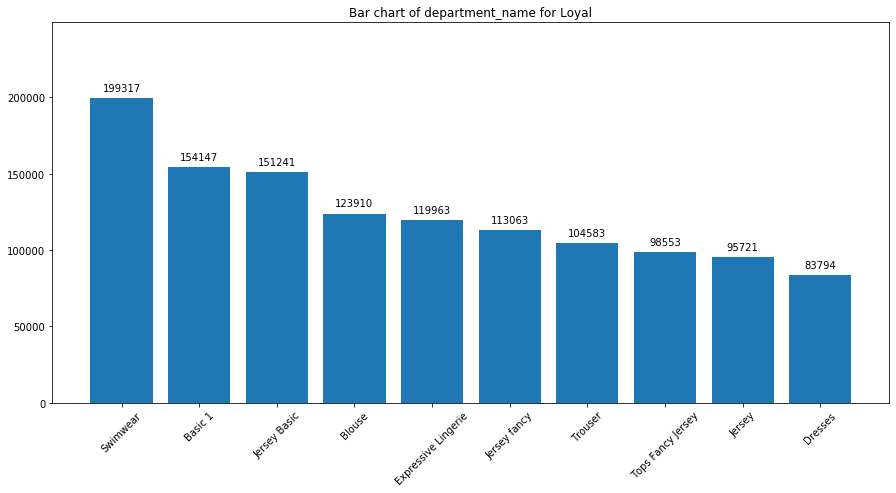



RFM Segment: Potential re-activation


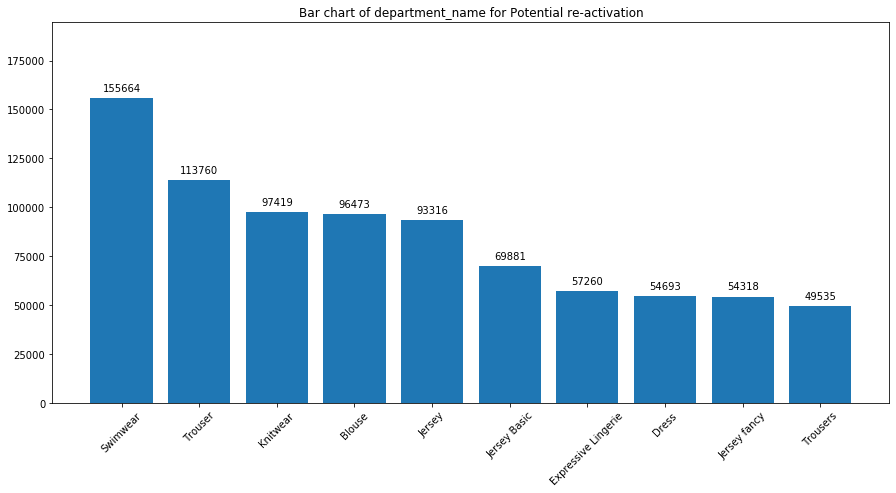



RFM Segment: Needs attention


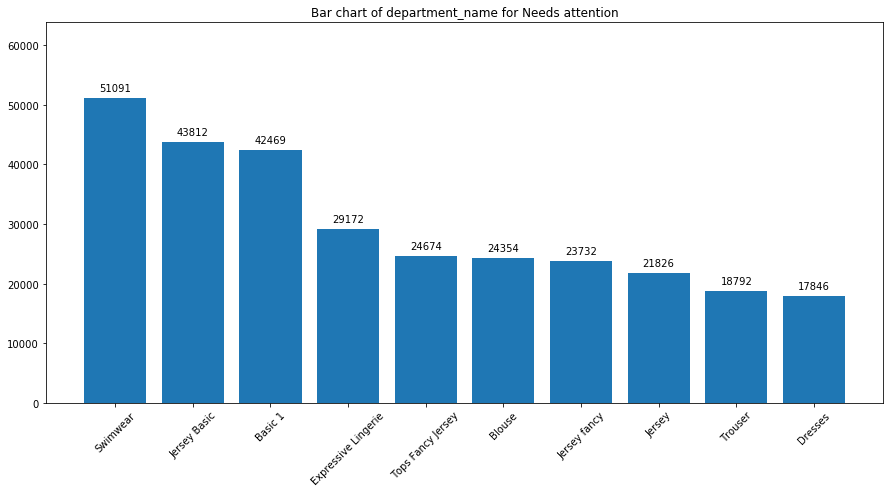



RFM Segment: Unprofitable


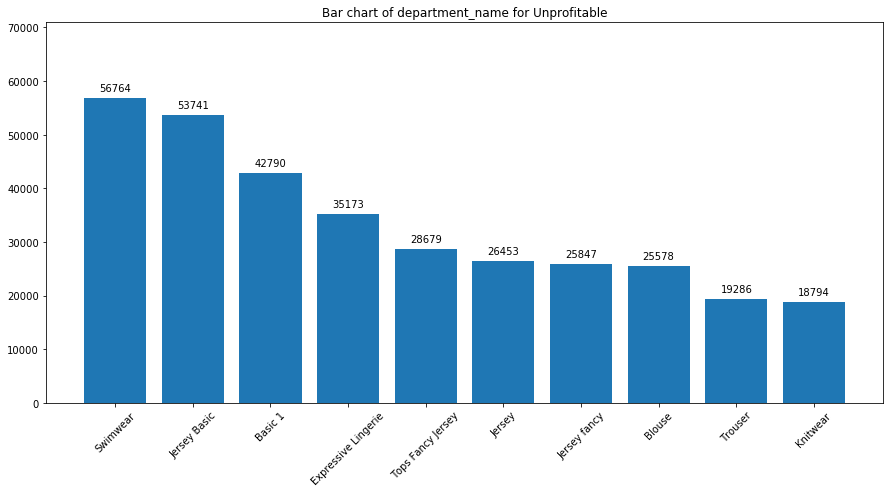



----- Variable: index_name -----
RFM Segment: Champions


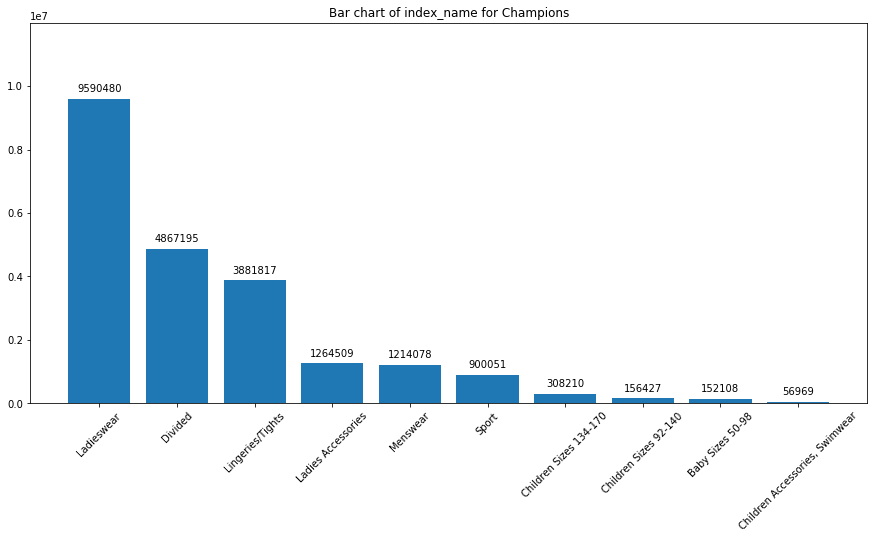



RFM Segment: Big spenders


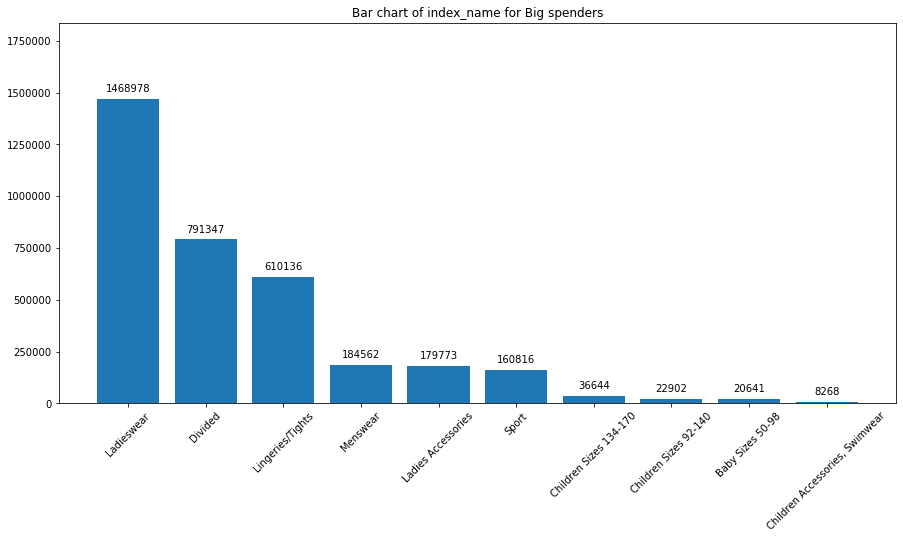



RFM Segment: Loyal


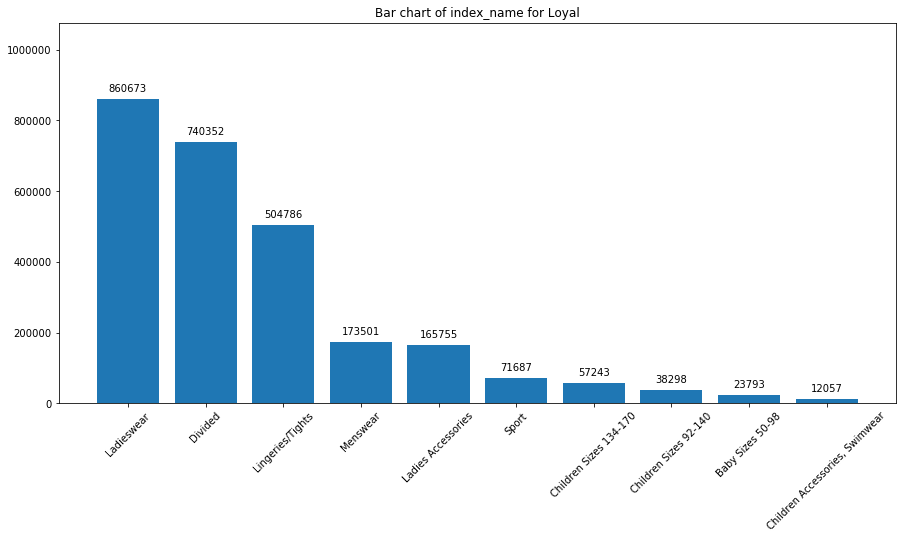



RFM Segment: Potential re-activation


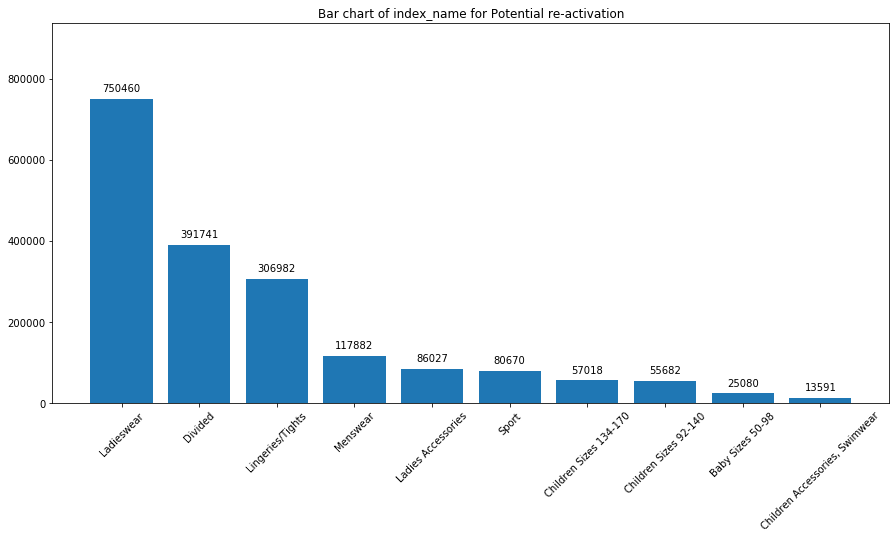



RFM Segment: Needs attention


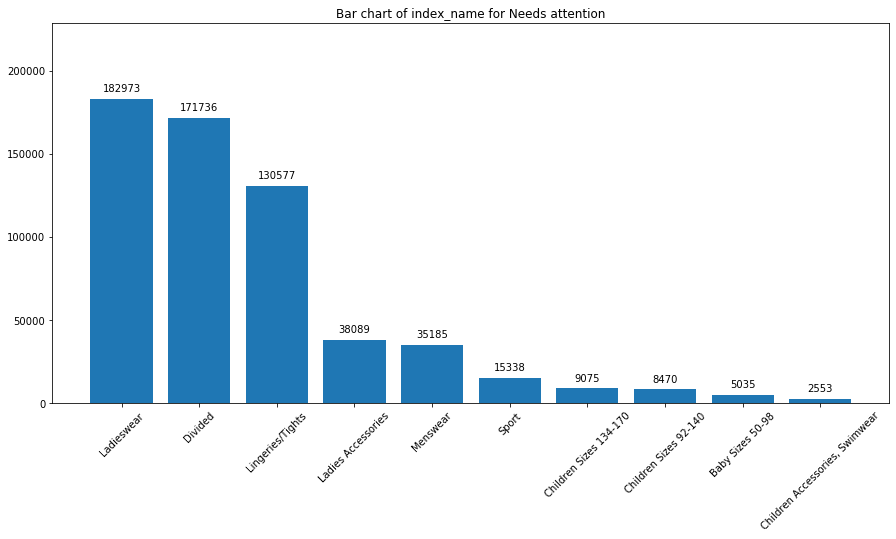



RFM Segment: Unprofitable


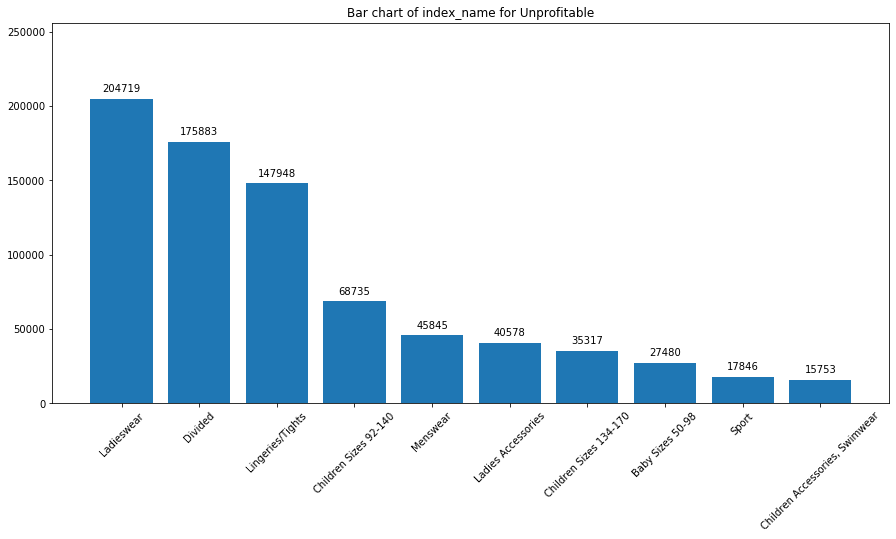



----- Variable: index_group_name -----
RFM Segment: Champions


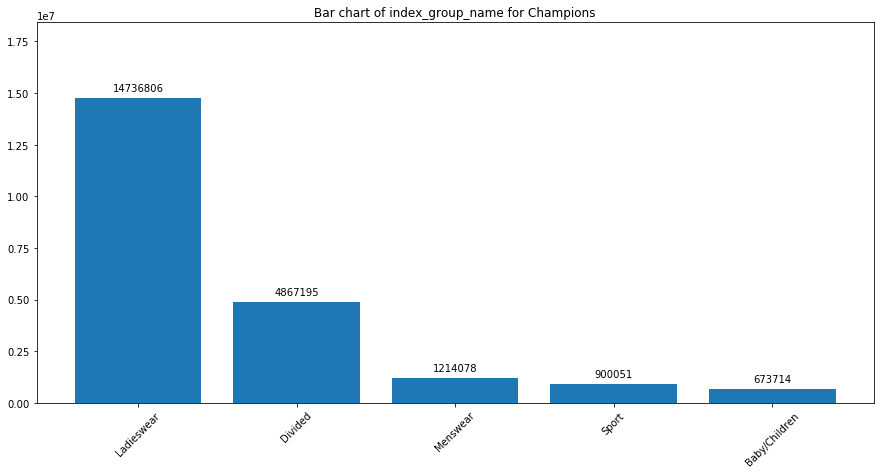



RFM Segment: Big spenders


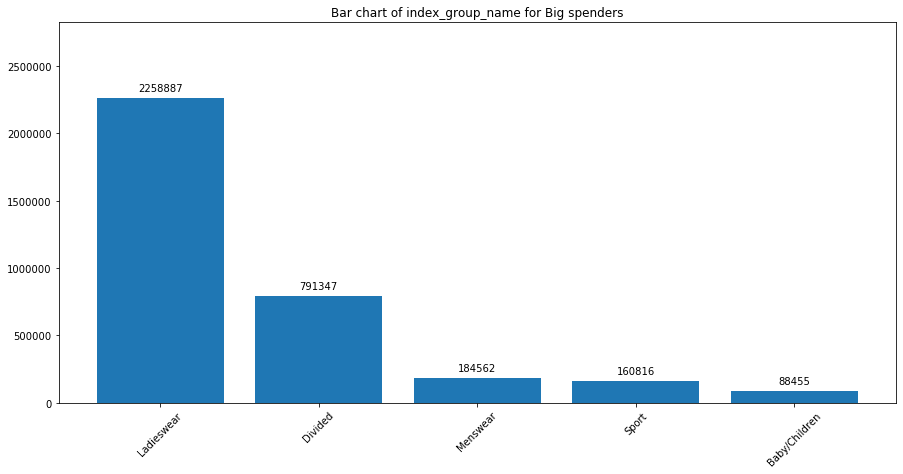



RFM Segment: Loyal


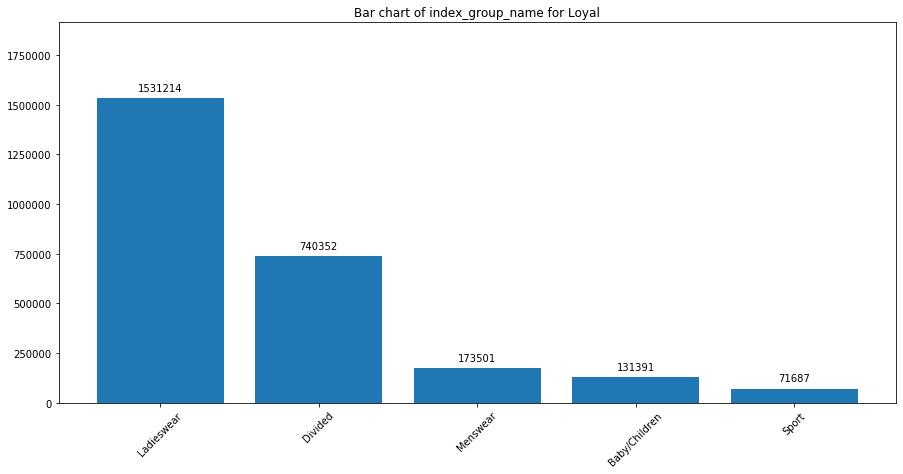



RFM Segment: Potential re-activation


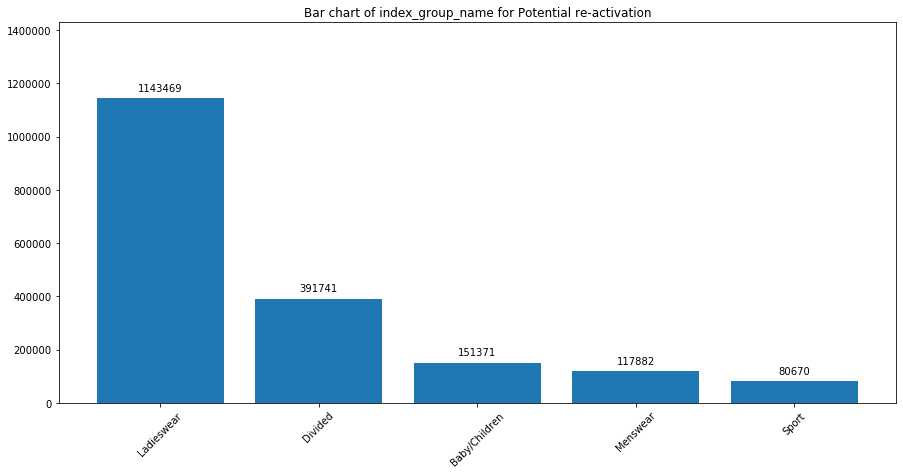



RFM Segment: Needs attention


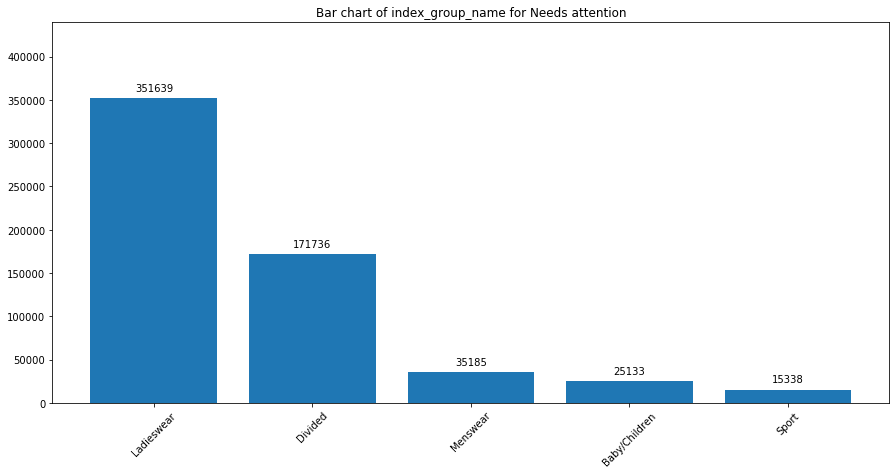



RFM Segment: Unprofitable


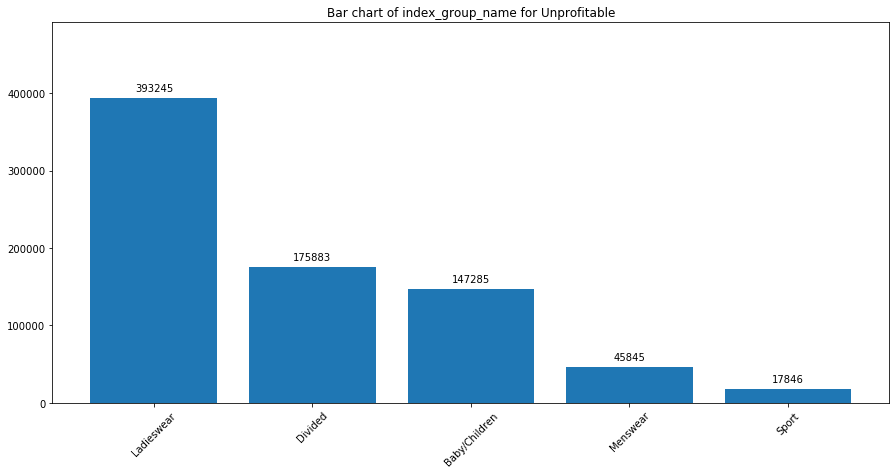



----- Variable: section_name -----
RFM Segment: Champions


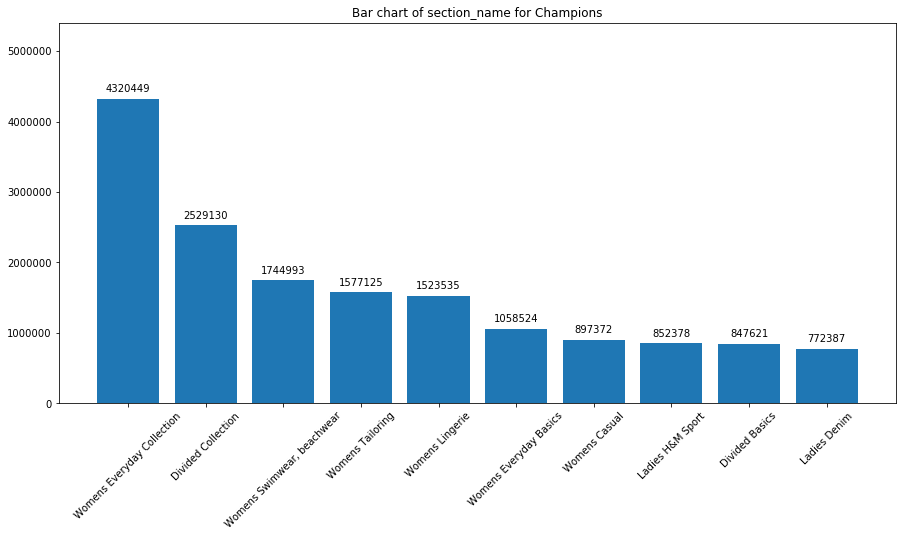



RFM Segment: Big spenders


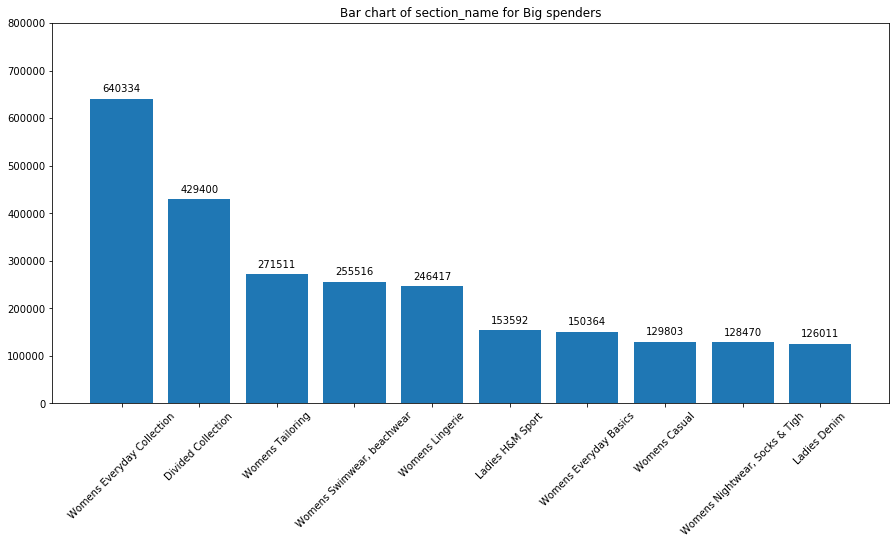



RFM Segment: Loyal


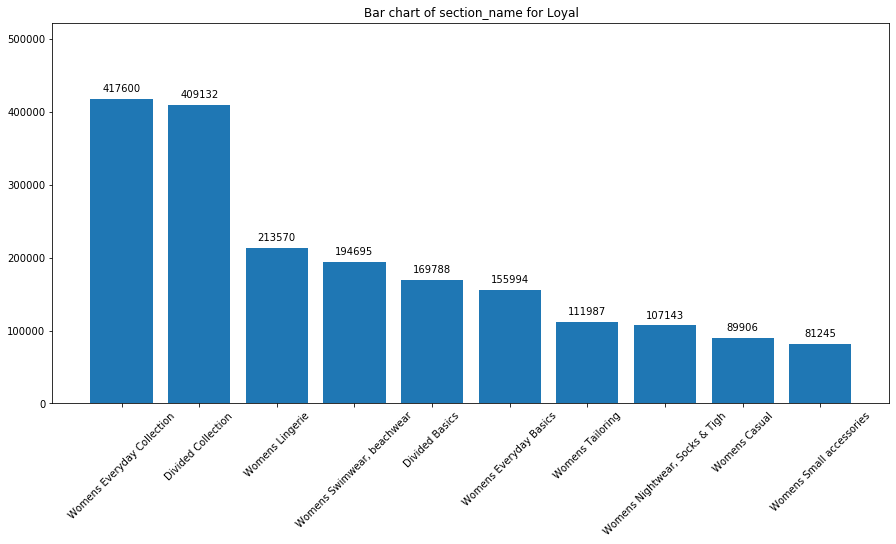



RFM Segment: Potential re-activation


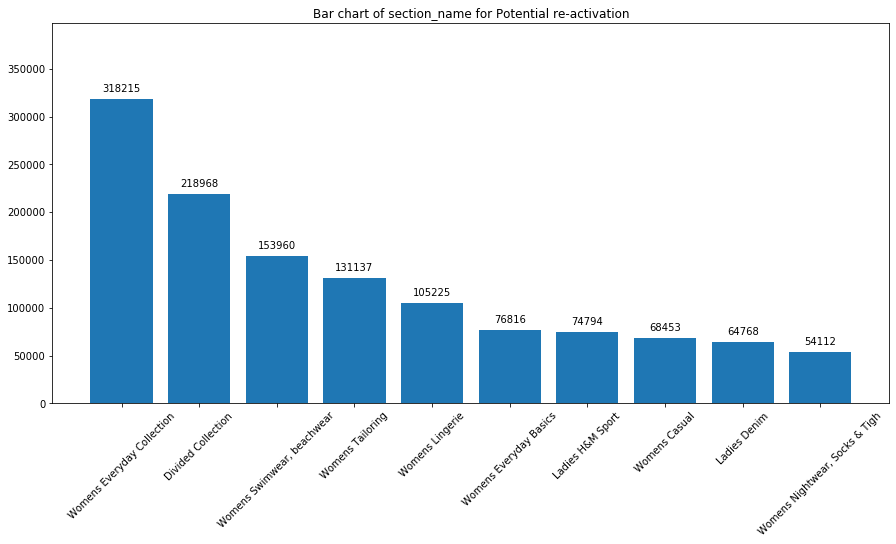



RFM Segment: Needs attention


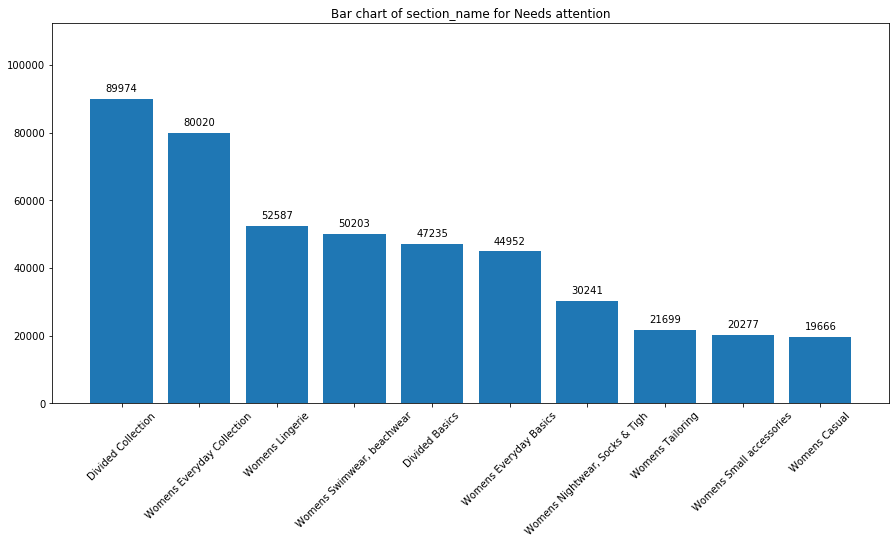



RFM Segment: Unprofitable


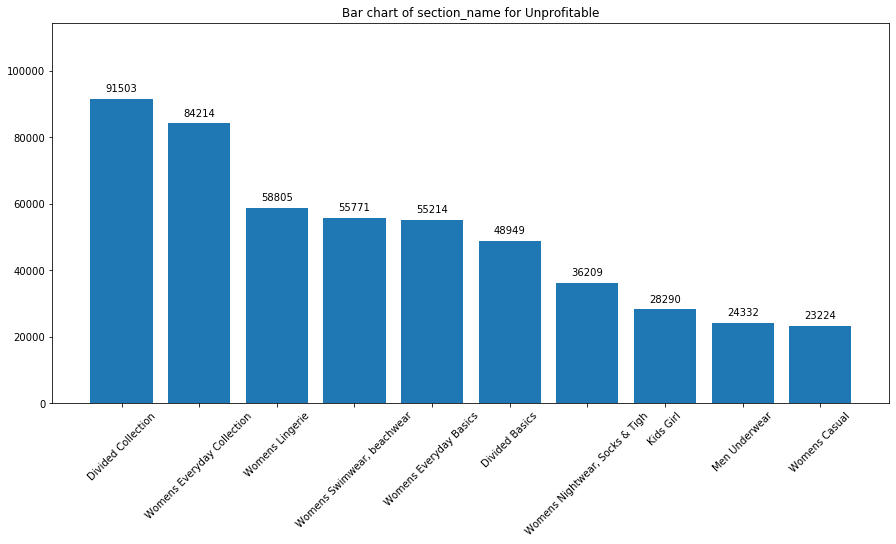



----- Variable: garment_group_name -----
RFM Segment: Champions


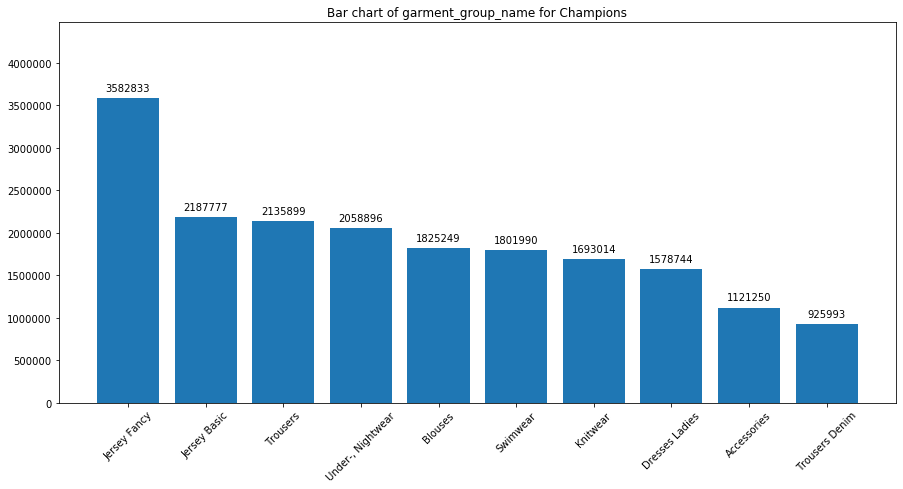



RFM Segment: Big spenders


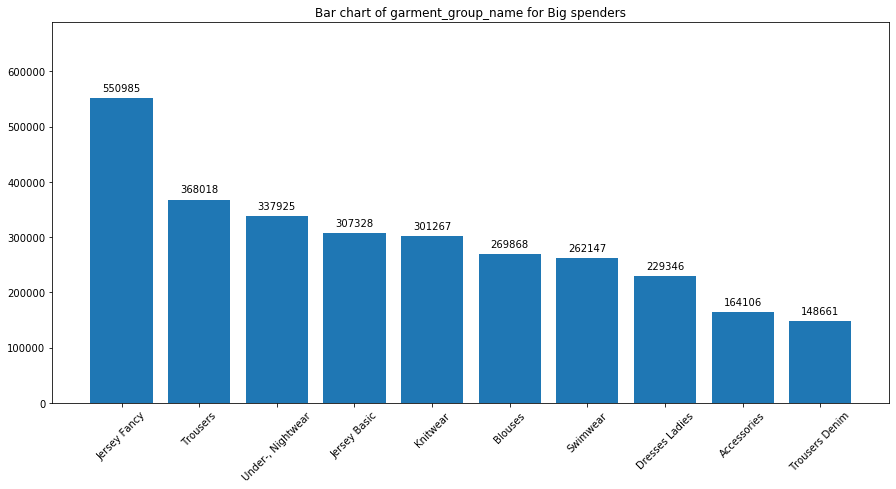



RFM Segment: Loyal


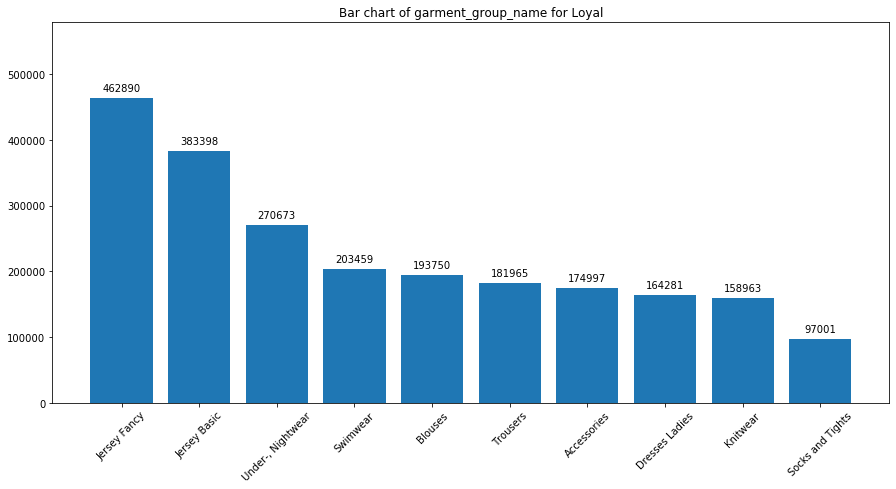



RFM Segment: Potential re-activation


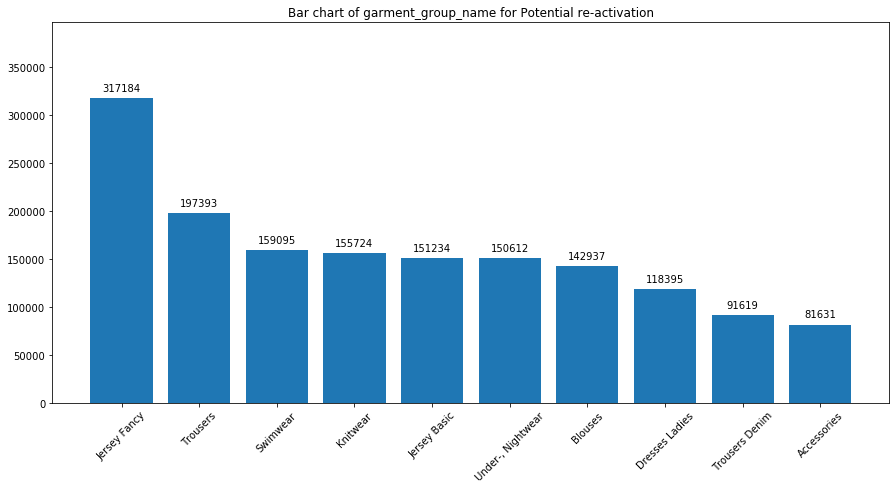



RFM Segment: Needs attention


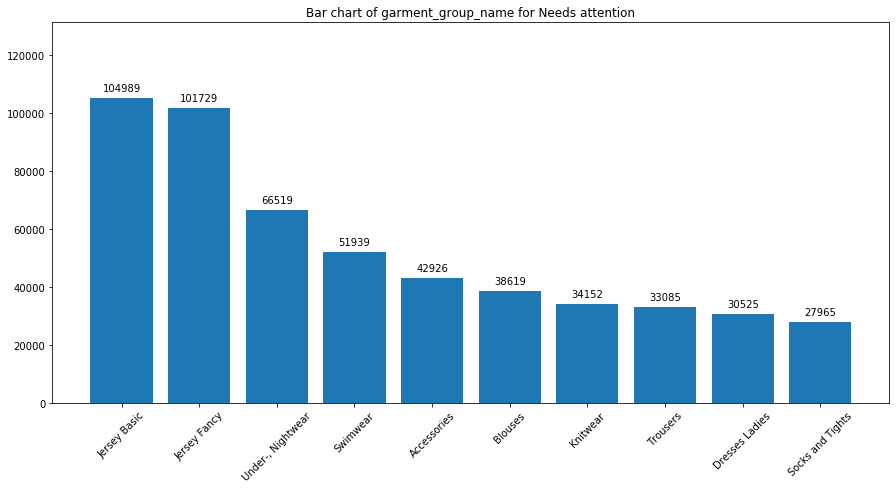



RFM Segment: Unprofitable


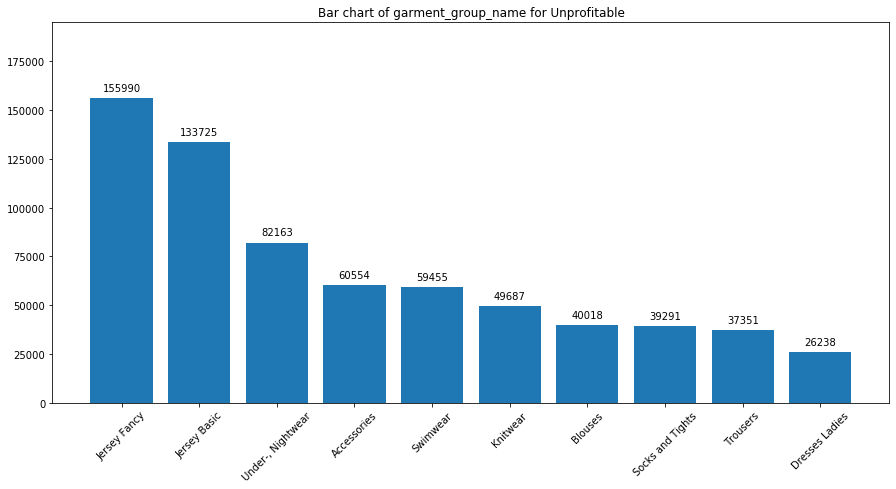

In [53]:
# Based on Top 10 categories in each column variable
labels = list(rfm_article_transact['rfm_label'].unique())
for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
           'perceived_colour_value_name','perceived_colour_master_name','department_name',
           'index_name','index_group_name','section_name','garment_group_name']:
    print('----- Variable:',col,'-----')
    for label in labels:
        print('RFM Segment:',label)
        subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
        value_counts = subset_df[col].value_counts().loc[lambda x: x>0].to_frame()
        if len(value_counts) > 10:
            value_counts = value_counts[:10]
        barplot(value_counts, label, col, value_counts.index, rotate=True)
        print('\n')